### Load accident data corresponding to far_part 121

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random

import collections
import matplotlib.pyplot as plt
%matplotlib inline

## New - With the implementation of eADMS in 2006, the "Events_Sequence" table will replace the "Occurrences"
## table and the "Findings" table will replace the "Seq_of_events" table.

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')  ## eADMS coding for accidents after 2006
aircraft = pd.read_excel('aircraft.xlsx')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events_ = pd.read_csv('seq_of_events.txt', sep = '\t') ## pre eADMS coding for accidents before 2006

narratives = pd.read_excel('narratives.xlsx')
metaData = pd.read_excel('metaData.xlsx')
events = pd.read_excel('events.xlsx')
engines = pd.read_excel('engines.xlsx')
injury = pd.read_excel('injury.xlsx')
findings = pd.read_excel('findings.xlsx')

In [2]:
Events_Sequence[Events_Sequence['ev_id'] == '20001208X08803']

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20001208X08803             1              3           400240   

                Occurrence_Description  phase_no  eventsoe_no  Defining_ev  \
0  Enroute - Loss of control in flight       400          240            1   

            lchg_date lchg_userid  
0  5/13/2019 14:50:49        bowl

In [3]:
print ('The values of cause_factor are', set(seq_of_events_['Cause_Factor'].values))

The values of cause_factor are {nan, 'D', ' ', 'c', 'C', 'F', '1', 'f', 'X', '2'}


#### Process the values of cause_factor

In [4]:
seq_of_events_[seq_of_events_['Cause_Factor'] == 'X']

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
58266   20001213X34629             1              2             1           2   
76321   20001213X31660             1              1             2           2   
103128  20001214X37504             1              4             1           1   
168019  20001213X33849             1              2             1           2   
197452  20001214X39233             1              2             3           1   
239753  20001211X15049             1              1             2           2   

        Subj_Code Cause_Factor  Modifier_Code  Person_Code  \
58266       24500            X           3131       4000.0   
76321       24539            X           3131       4000.0   
103128      20200            X           2511          0.0   
168019      24551            X           3113       4000.0   
197452      20000            X           2207          0.0   
239753      24551            X           3113       4000.0   

                  lchg_date         lchg_userid  
58266   12/13/2000 16:58:22  dbo                 
76321   12/13/2000 14:40:01  dbo                 
103128  12/14/2000 13:05:05  dbo                 
168019  12/13/2000 16:13:55  dbo                 
197452  12/14/2000 14:24:49  dbo                 
239753  12/11/2000 15:07:06  dbo

In [5]:
seq_of_events = seq_of_events_.dropna(axis = 0, subset =['Cause_Factor'])

In [6]:
seq_of_events.loc[seq_of_events.Cause_Factor == '1','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == '2','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'c','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'f','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'D','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'X','Cause_Factor'] = 'F'

indexes = seq_of_events[seq_of_events['Cause_Factor'] == ' '].index
seq_of_events.drop(indexes, inplace = True)

C:\anaconda3\envs\bayesian-network\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\anaconda3\envs\bayesian-network\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
set(seq_of_events['Cause_Factor'].values)

{'C', 'F'}

In [8]:
metaData['code_iaids'] = metaData['code_iaids'].astype(str)
indices = seq_of_events[seq_of_events['Subj_Code'] == 0].index
seq_of_events.drop(indices, inplace = True)

In [9]:
indices

Int64Index([133286, 163656, 163657, 246474], dtype='int64')

### Accident Statistical Summary

#### Total number of accidents in far_part 121

In [10]:
ev_ID = aircraft['ev_id'].values.tolist()

## Remove duplicated event IDs
ev_ID = list(set(ev_ID))

print ('There are {} accidents in NTSB database with far_part equal to 121'.format(len(ev_ID)))
print ('The data ranges from {} to {}'.format(min(events['ev_year'].values), max(events['ev_year'].values)))

There are 2243 accidents in NTSB database with far_part equal to 121
The data ranges from 1982 to 2019


#### Basic statistics

In [11]:
events_part = events[events['ev_id'].isin(ev_ID)]

In [12]:
events_part['ev_highest_injury'].fillna('Not Reported', inplace = True)

In [13]:
from itertools import product
combs = pd.DataFrame(list(product(set(events_part['ev_year'].values), set(events_part['ev_highest_injury'].values))), 
                     columns=['ev_year', 'ev_highest_injury'])

In [14]:
g = events_part.groupby(['ev_year','ev_highest_injury']).size().to_frame('count').reset_index()
g

ev_year ev_highest_injury  count
0       1982              FATL      5
1       1982              MINR      5
2       1982              NONE     27
3       1982              SERS      8
4       1983              FATL      4
..       ...               ...    ...
167     2019              FATL      1
168     2019              MINR      2
169     2019      Not Reported      4
170     2019              SERS      2
171     2019              UNKN      2

[172 rows x 3 columns]

In [15]:
result = g.merge(combs, how = 'right').fillna(0)

In [16]:
FATL_res = result[result['ev_highest_injury'] == 'FATL'].sort_values(by=['ev_year'])
MINR_res = result[result['ev_highest_injury'] == 'MINR'].sort_values(by=['ev_year'])
NONE_res = result[result['ev_highest_injury'] == 'NONE'].sort_values(by=['ev_year'])
SERS_res = result[result['ev_highest_injury'] == 'SERS'].sort_values(by=['ev_year'])
UNKN_res = result[result['ev_highest_injury'] == 'UNKN'].sort_values(by=['ev_year'])
No_Report_res = result[result['ev_highest_injury'] == 'Not Reported'].sort_values(by=['ev_year'])

In [17]:
aircraft['damage'].fillna('Not Reported', inplace = True)

In [18]:
aircraft['ev_year'] = aircraft['ev_id'].astype(str).str[:4]

from itertools import product
aicrftCombs = pd.DataFrame(list(product(set(aircraft['ev_year'].values), set(aircraft['damage'].values))), 
                     columns=['ev_year', 'damage'])

aircraftDamage = aircraft['damage'].groupby([aircraft['ev_year'], aircraft['damage']]).size().to_frame('count').reset_index()

aircraftResult = aircraftDamage.merge(aicrftCombs, how = 'right').fillna(0)

In [19]:
aircraftResult[aircraftResult['ev_year'] == '2015']

ev_year        damage  count
58    2015          MINR    6.0
59    2015          NONE   21.0
60    2015  Not Reported    1.0
61    2015          SUBS    7.0
89    2015           UNK    0.0
90    2015          DEST    0.0

In [20]:
aircraftResult.loc[aircraftResult['ev_year'] == '2000']

ev_year        damage  count
0     2000          DEST   60.0
1     2000          MINR  472.0
2     2000          NONE  532.0
3     2000          SUBS  246.0
4     2000           UNK    1.0
85    2000  Not Reported    0.0

In [21]:
aircraftResult

ev_year        damage  count
0      2000          DEST   60.0
1      2000          MINR  472.0
2      2000          NONE  532.0
3      2000          SUBS  246.0
4      2000           UNK    1.0
..      ...           ...    ...
115    2014           UNK    0.0
116    2014          DEST    0.0
117    2014  Not Reported    0.0
118    2004           UNK    0.0
119    2004  Not Reported    0.0

[120 rows x 3 columns]

In [22]:
idx = aircraftResult.index[aircraftResult['ev_year'] == '2000']

aircraftResult.drop(list(idx), inplace = True)

###### Aircraft damage VS year

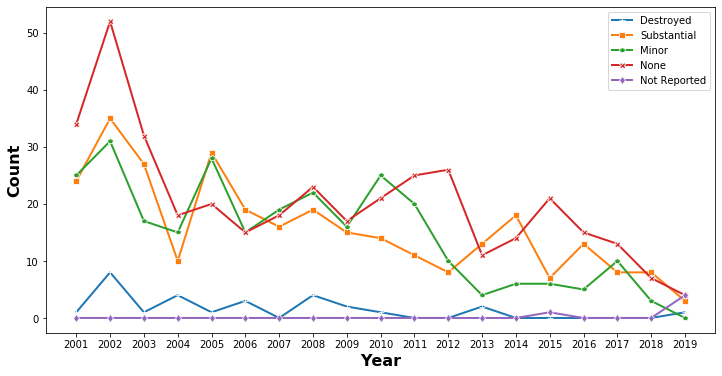

In [23]:
aircraft_DEST_res = aircraftResult[aircraftResult['damage'] == 'DEST'].sort_values(by=['ev_year'])
aircraft_SERS_res = aircraftResult[aircraftResult['damage'] == 'SUBS'].sort_values(by=['ev_year'])
aircraft_MINR_res = aircraftResult[aircraftResult['damage'] == 'MINR'].sort_values(by=['ev_year'])
aircraft_NONE_res = aircraftResult[aircraftResult['damage'] == 'NONE'].sort_values(by=['ev_year'])
aircraft_UNKN_res = aircraftResult[aircraftResult['damage'] == 'Not Reported'].sort_values(by=['ev_year'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(aircraft_DEST_res['ev_year'].values, aircraft_DEST_res['count'].values, marker = '+', lw = 2)
sns.lineplot(aircraft_SERS_res['ev_year'].values, aircraft_SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(aircraft_MINR_res['ev_year'].values, aircraft_MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(aircraft_NONE_res['ev_year'].values, aircraft_NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(aircraft_UNKN_res['ev_year'].values, aircraft_UNKN_res['count'].values, marker = 'd', lw = 2)
plt.legend(['Destroyed', 'Substantial', 'Minor', 'None', 'Not Reported'])
plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.savefig('damage_vs_year.pdf')

##### Injury VS year

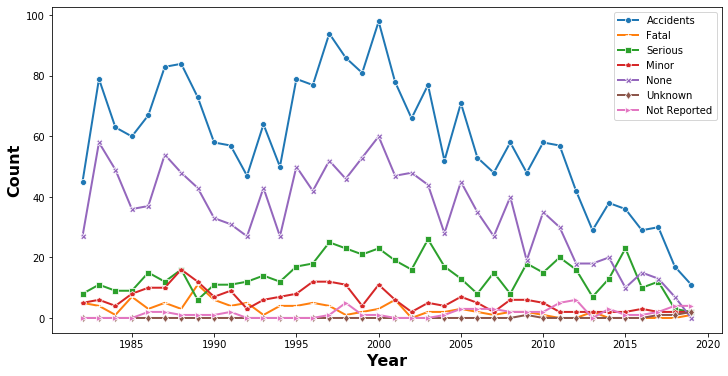

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

noEventsbyYear = events_part['ev_year'].groupby(events_part['ev_year'].rename('year')).agg({'count'})
sns.lineplot(No_Report_res['ev_year'].values, noEventsbyYear['count'], marker = 'o', lw = 2)

sns.lineplot(FATL_res['ev_year'].values, FATL_res['count'].values, marker = '+', lw = 2)
sns.lineplot(SERS_res['ev_year'].values, SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(MINR_res['ev_year'].values, MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(NONE_res['ev_year'].values, NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(UNKN_res['ev_year'].values, UNKN_res['count'].values, marker = 'd', lw = 2)
sns.lineplot(No_Report_res['ev_year'].values, No_Report_res['count'].values, marker = '>', lw = 2)

plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.legend(['Accidents', 'Fatal', 'Serious', 'Minor', 'None', 'Unknown', 'Not Reported'])
plt.savefig('injury_vs_year.pdf')

#### Accident vs Aircraft Manufactuer

In [25]:
acft_make_counter = collections.Counter(aircraft['acft_make'].str.title())
acft_make_counter_plot = {k: v for k, v in acft_make_counter.items() if v > 5}

Text(0, 0.5, 'No of accidents')

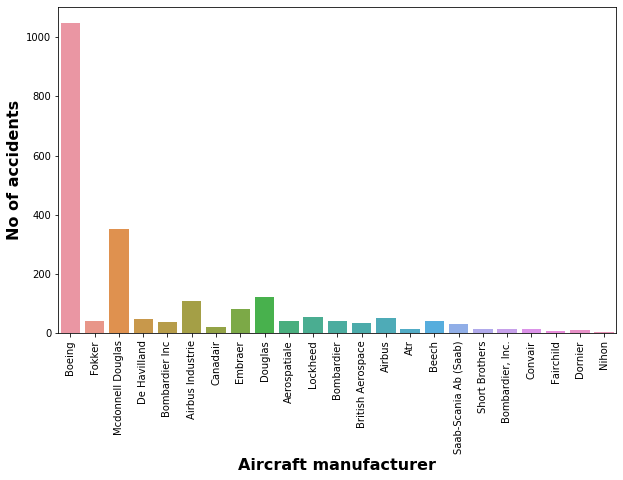

In [26]:
plt.figure(figsize = (10, 6))
sns.barplot(list(acft_make_counter_plot.keys()), list(acft_make_counter_plot.values()))
plt.xticks(rotation=90)
plt.xlabel('Aircraft manufacturer', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of accidents', fontsize = 16, fontweight = 'bold')

#### Accident vs Event Type

In [27]:
ev_type_counter = collections.Counter(events['ev_type'].fillna('Unknown'))
ev_type_keys = ['Accident','Incident','Unknown']

Text(0, 0.5, 'No of events')

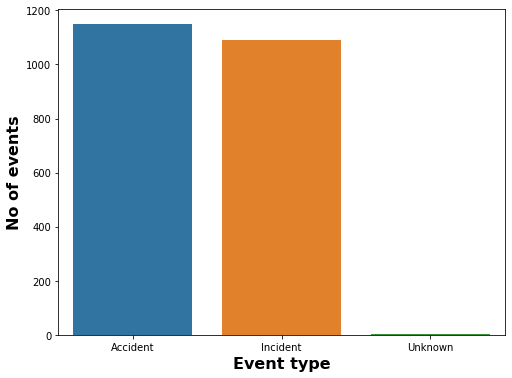

In [28]:
plt.figure(figsize = (8, 6))
sns.barplot(ev_type_keys, list(ev_type_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Year

Text(0, 0.5, 'No of events')

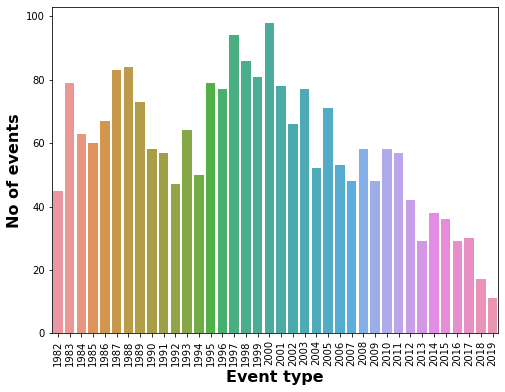

In [29]:
ev_year_counter = collections.Counter(events['ev_year'])

plt.figure(figsize = (8, 6))
sns.barplot(list(ev_year_counter.keys()), list(ev_year_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs State

Text(0, 0.5, 'No of events')

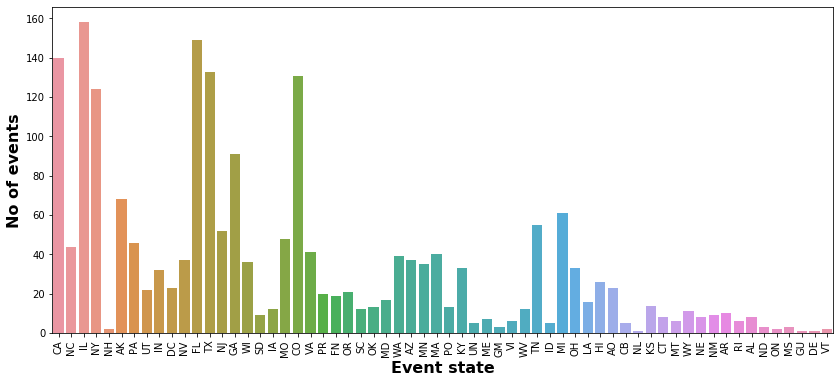

In [30]:
ev_state_counter = collections.Counter(events['ev_state'])

plt.figure(figsize = (14, 6))
sns.barplot(list(ev_state_counter.keys()), list(ev_state_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event state', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Wind Gusting

In [31]:
gust_ind_counter = collections.Counter(events['gust_ind'].fillna('Not Reported'))
gust_ind_keys = ['Not Gusting', 'Gusting', 'Unknown', 'Not Reported']

Text(0, 0.5, 'No of events')

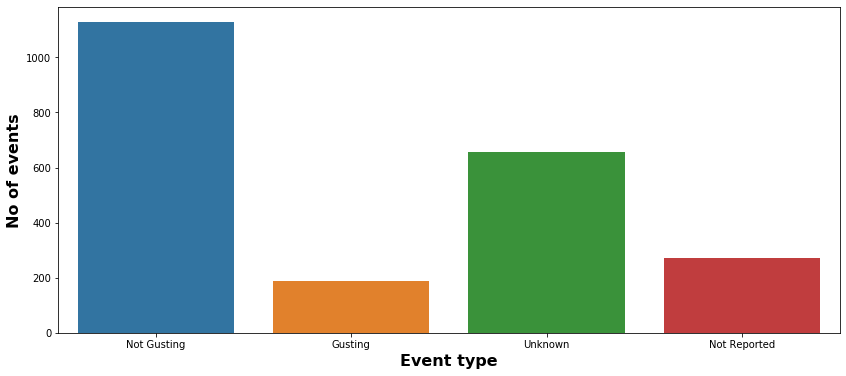

In [32]:
plt.figure(figsize = (14, 6))
sns.barplot(gust_ind_keys, list(gust_ind_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airport Elevation

In [33]:
elevation = events['apt_elev'].values
elevation = elevation[~np.isnan(elevation)]

Text(0, 0.5, 'Probability')

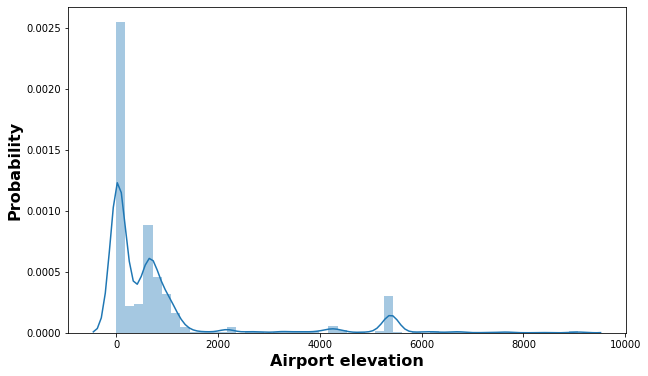

In [34]:
plt.figure(figsize = (10, 6))
sns.distplot(elevation)
plt.xlabel('Airport elevation', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Accident vs Highest Injury

Text(0, 0.5, 'No of events')

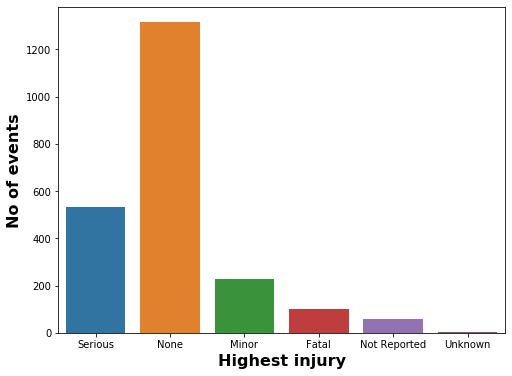

In [35]:
ev_highest_injury_counter = collections.Counter(events['ev_highest_injury'].fillna('Not Reported'))
ev_highest_injury_keys = ['Serious', 'None', 'Minor', 'Fatal', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_highest_injury_keys, list(ev_highest_injury_counter.values()))
plt.xlabel('Highest injury', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Aircraft Damage

In [36]:
ev_aircraft_damage_counter = collections.Counter(aircraft['damage'].fillna('Not Reported'))
ev_aircraft_damage_counter

Counter({'NONE': 918,
         'SUBS': 543,
         'MINR': 749,
         'DEST': 88,
         'Not Reported': 5,
         'UNK': 5})

#### Accident vs Location

Text(0, 0.5, 'No of events')

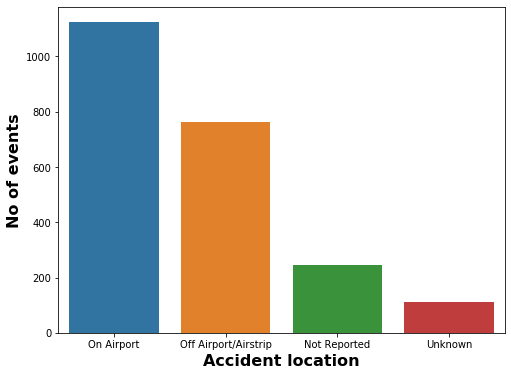

In [37]:
ev_nr_apt_loc_counter = collections.Counter(events['ev_nr_apt_loc'].fillna('Not Reported'))
ev_nr_apt_loc_keys = ['On Airport', 'Off Airport/Airstrip', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_nr_apt_loc_keys, list(ev_nr_apt_loc_counter.values()))
plt.xlabel('Accident location', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Light Condition

In [38]:
light_cond_counter = collections.Counter(events['light_cond'].fillna('Unknown'))

light_cond_keys = ['Day','Night/Dark','Night', 'Not Reported', 'Condition-Unknown', 'Dusk', 'Dawn', 'Night//Bright']

Text(0, 0.5, 'No of events')

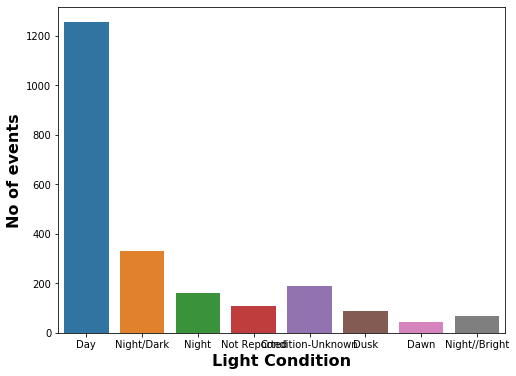

In [39]:
plt.figure(figsize = (8, 6))
sns.barplot(light_cond_keys, list(light_cond_counter.values()))
plt.xlabel('Light Condition', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Engine Type

In [40]:
eng_type_counter = collections.Counter(engines['eng_type'].fillna('Not Reported'))
eng_type_keys = ['Turbo Fan', 'Turbo Prop', 'Unknown', 'Turbo Jet', 'Reciprocating', 'Not Reported', 'Turbo Shaft']

Text(0, 0.5, 'No of events')

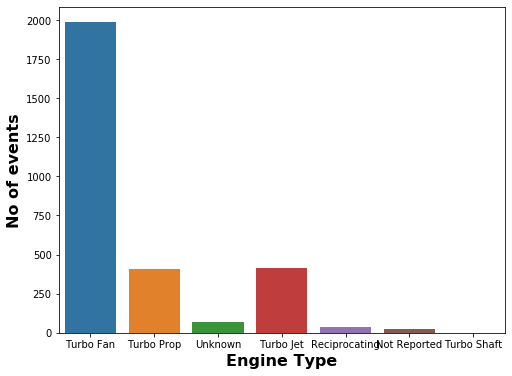

In [41]:
plt.figure(figsize = (8, 6))
sns.barplot(eng_type_keys, list(eng_type_counter.values()))
plt.xlabel('Engine Type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airframe Hours

Text(0, 0.5, 'Probability')

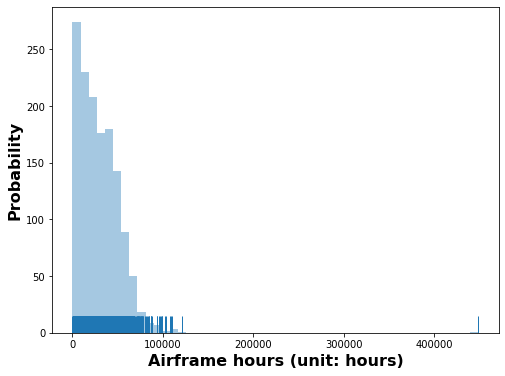

In [42]:
afm_hrs = aircraft['afm_hrs'].values
afm_hrs = afm_hrs[~np.isnan(afm_hrs)]

plt.figure(figsize = (8, 6))
sns.distplot(afm_hrs, kde=False, rug=True)
plt.xlabel('Airframe hours (unit: hours)', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Aircraft Basic Characteristics

In [43]:
aircraft['num_eng']

0       2.0
1       2.0
2       3.0
3       2.0
4       4.0
       ... 
2303    2.0
2304    NaN
2305    2.0
2306    2.0
2307    2.0
Name: num_eng, Length: 2308, dtype: float64

In [44]:
aircraft['oper_pax_cargo']

0        PAX
1       CARG
2       PACA
3       PACA
4       PACA
        ... 
2303     PAX
2304     PAX
2305     PAX
2306     PAX
2307     PAX
Name: oper_pax_cargo, Length: 2308, dtype: object

In [45]:
events['light_cond']

0       DAYL
1       DAYL
2       DAYL
3       DAYL
4       DAYL
        ... 
2238    DAYL
2239      NR
2240    NITE
2241    DAYL
2242    DAYL
Name: light_cond, Length: 2243, dtype: object

In [46]:
import pygraphviz as pgv
from IPython.display import display, Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

## Build Bayesian Network from Event Sequences

In [47]:
ev_ID

['20001212X19854',
 '20110209X55126',
 '20070223X00215',
 '20050106X00021',
 '20001214X44459',
 '20001212X24243',
 '20080513X00660',
 '20081124X34243',
 '20010910X01911',
 '20080413X00464',
 '20040419X00477',
 '20001207X04953',
 '20001213X28286',
 '20001212X20771',
 '20001213X26302',
 '20001214X35501',
 '20080118X00073',
 '20001213X31745',
 '20090323X01952',
 '20090213X13613',
 '20001213X33518',
 '20021112X05460',
 '20001211X11006',
 '20001207X04911',
 '20050613X00760',
 '20130519X11737',
 '20030505X00618',
 '20140918X52311',
 '20001205X00131',
 '20110513X41407',
 '20080424X00538',
 '20001211X09833',
 '20020917X02737',
 '20001211X10653',
 '20001212X20649',
 '20001213X33116',
 '20050104X00010',
 '20001208X07004',
 '20081003X62950',
 '20001212X22522',
 '20001211X15150',
 '20001204X00105',
 '20001213X31332',
 '20130220X32821',
 '20001212X19442',
 '20121231X42414',
 '20150812X63537',
 '20001208X07264',
 '20001211X11666',
 '20020123X00106',
 '20120719X94744',
 '20001211X10440',
 '20010911X0

In [48]:
import re
def calculate_injury_level(ev_ID):    
    Fatal = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'FATL')]['inj_person_count'].values)
    Serious = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'SERS')]['inj_person_count'].values)
    Minor = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'MINR')]['inj_person_count'].values)
    No = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'NONE')]['inj_person_count'].values)
    Total = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'TOTL')]['inj_person_count'].values)
    
    dict_injury = {}
    if Total != 0:
        dict_injury['Fatal'] = Fatal/Total
        dict_injury['Serious'] = Serious/Total
        dict_injury['Minor'] = Minor/Total
        dict_injury['NONE'] = No/Total
        
        if dict_injury['Fatal'] > 0:
            return 'Fatalinjury'
        elif dict_injury['Serious'] > 0:
            return 'Seriousinjury'
        elif dict_injury['Minor'] > 0:
            return 'Minorinjury'
        else:
            return 'Noinjury'
    else:
        return 'Noinjury'

def deriveNamebyCode(code):
    try:
        label = metaData[metaData['code_iaids'] == code]['meaning'].values[0]
        name = re.sub('[^a-zA-Z]+', '', label)  
    except:
        return 'Unknownquantity', 'Unknown quantity'
    
    return name, label

In [49]:
#sample_ev_ID = '20001213X29335'
sample_ev_ID = '20001213X29335'
example = narratives[narratives['ev_id'] == sample_ev_ID]
list(example['narr_accp'])

[nan]

In [50]:
sample_ev_ID

'20001213X29335'

In [51]:
seq_of_events_[seq_of_events_['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
165126  20001213X29335             1              1             1           2   
165127  20001213X29335             1              2             1           2   
165128  20001213X29335             1              3             1           1   

        Subj_Code Cause_Factor  Modifier_Code  Person_Code  \
165126      22120            C           3109       4000.0   
165127      24505            C           3104       4000.0   
165128      20200                        2506          0.0   

                  lchg_date         lchg_userid  
165126  12/13/2000 13:05:36  dbo                 
165127  12/13/2000 13:05:36  dbo                 
165128  12/13/2000 13:05:36  dbo

In [52]:
seq_of_events[seq_of_events['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
165126  20001213X29335             1              1             1           2   
165127  20001213X29335             1              2             1           2   

        Subj_Code Cause_Factor  Modifier_Code  Person_Code  \
165126      22120            C           3109       4000.0   
165127      24505            C           3104       4000.0   

                  lchg_date         lchg_userid  
165126  12/13/2000 13:05:36  dbo                 
165127  12/13/2000 13:05:36  dbo

In [53]:
occurrences[occurrences['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
63571  20001213X29335             1              1              260   
63572  20001213X29335             1              2              340   
63573  20001213X29335             1              3              310   

       Phase_of_Flight  Altitude            lchg_date         lchg_userid  
63571              521         0  12/13/2000 13:05:36  dbo                 
63572              523         0  12/13/2000 13:05:36  dbo                 
63573              523         0  12/13/2000 13:05:36  dbo

In [54]:
a = set(occurrences[occurrences['Occurrence_Code'] == 340]['ev_id'].values)
ids = a.intersection(set(ev_ID))

In [55]:
aircraft[aircraft['ev_id'] == sample_ev_ID]['afm_hrs']

1448    2235.0
Name: afm_hrs, dtype: float64

In [56]:
dictEdges = {}

lst = ['eventId', 'from', 'to']
df_records = pd.DataFrame(columns=lst)

def addEdges(key, ev_ID):
    if key in dictEdges.keys():
        dictEdges[key] += 1
    else:
        dictEdges[key] = 1
    
    global df_records
    fromNode, toNode = key.split('->')
    row = {'eventId': ev_ID, 'from': fromNode, 'to': toNode}
    df_records = df_records.append(row, ignore_index=True)
        
dictNodeLabel = {}
def addNodeLabel(key, value):
    if key == 'Flightcrew':
        dictNodeLabel[key] = 'Flight crew'
        return
    if key not in dictNodeLabel.keys():
        dictNodeLabel[key] = value
        
dictNodeLabel['Fatalinjury'] = 'Fatal injury'
dictNodeLabel['Seriousinjury'] = 'Serious injury'
dictNodeLabel['Minorinjury'] = 'Minor injury'
dictNodeLabel['Noinjury'] = 'No injury'
dictNodeLabel['Unknownreason'] = 'Unknown reason'

In [57]:
def buildOneGraphRep(sample_ev_ID):
    subjectName = []

    g1 = "digraph top {"
    g1 += """size ="12,12"; """
    g1 += "graph [compound=true];"

    ev_year = events[events['ev_id'] == sample_ev_ID]['ev_year'].values[0]
    if ev_year <= 2006:
        eventSequences = seq_of_events[seq_of_events['ev_id'] == sample_ev_ID][['Occurrence_No', 'seq_event_no', 
                                                                                'Subj_Code', 'Modifier_Code', 'Person_Code']]
            
        ## Construct the subject name
        subjectList = []
        for index, row in eventSequences.iterrows():
            Subj_Code = str(int(row['Subj_Code']))
            Modifier_Code = str(int(row['Modifier_Code']))
            Person_Code = str(int(row['Person_Code']))
            Occurrence_No = int(row['Occurrence_No'])

            subjectName, subjectLabel = deriveNamebyCode(Subj_Code)
            
            if Modifier_Code != '0':
                modifierName, modifierLabel = deriveNamebyCode(Modifier_Code)
                
                if len(modifierName) > 0:
                    #subjectName = subjectName + modifierName
                    subjectLabel = subjectLabel# + ':' + modifierLabel

            g1 += subjectName + ' [label =' + '"' + subjectLabel + '"'+ '];'
            subjectList.append([Occurrence_No, subjectName])
            addNodeLabel(subjectName, subjectLabel)

            if Person_Code != '0':
                personName, personeLabel = deriveNamebyCode(Person_Code)
                g1 += personName + '[label = ' + '"' + personeLabel + '"' + '];'
                g1 += personName + '->' + subjectName + ';'
                addEdges(personName + '->' + subjectName, sample_ev_ID)
                addNodeLabel(personName, personeLabel)

        ## construct sequence of occurrence
        eventOccurrences = occurrences[occurrences['ev_id'] == sample_ev_ID][['Occurrence_Code', 'Phase_of_Flight']]
        occurrenceCount = 0
        OccurrenceName = ''
        
        for index, row in eventOccurrences.iterrows():
            Occurrence_Code = str(row['Occurrence_Code'])
            Phase_of_Flight = str(row['Phase_of_Flight'])

            prevOccurrence = OccurrenceName
            OccurrenceName, OccurrenceLabel  = deriveNamebyCode(Occurrence_Code)
            flightPhaseName, flightPhaseLabel = deriveNamebyCode(Phase_of_Flight)

            g1 += OccurrenceName + ' [label = ' + '"' + OccurrenceLabel + '"' + ', style=filled, color=".2 .5 0.9"];'
            addNodeLabel(OccurrenceName, OccurrenceLabel)
            addNodeLabel(flightPhaseName, flightPhaseLabel)
            
            for subject in subjectList:
                if subject[0] == occurrenceCount + 1:
                    connection = subject[1] + '->' + OccurrenceName + ';'
                    if connection not in g1:
                        g1 += subject[1] + '->' + OccurrenceName + ';'
                        addEdges(subject[1] + '->' + OccurrenceName, sample_ev_ID)
            
            if occurrenceCount == 0:
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                #addEdges(flightPhaseName + '->' + OccurrenceName)
                pass
            
            if occurrenceCount >= 1:
                g1 += prevOccurrence + '->' + OccurrenceName + ';'
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                
                addEdges(prevOccurrence + '->' + OccurrenceName, sample_ev_ID)
                #addEdges(flightPhaseName + '->' + OccurrenceName)

            occurrenceCount += 1

        ## Outcome of accident
        aircraftDamageLevel = aircraft[aircraft['ev_id'] == sample_ev_ID]['damage'].values[0]
        aircraftDamageName = dictAircraftDamage[aircraftDamageLevel] + 'aircraftdamage'
        aircraftDamageLabel = dictAircraftDamage[aircraftDamageLevel] + ' aircraft damage'
        addNodeLabel(aircraftDamageName, aircraftDamageLabel)
        
        g1 += aircraftDamageName + '[label = ' + '"'+ aircraftDamageLabel + '"' +', style=filled];'
        
        if OccurrenceName == '':
            OccurrenceName = 'Unknownreason'
            
        g1 += OccurrenceName + '->' + aircraftDamageName + ';'
        addEdges(OccurrenceName + '->' + aircraftDamageName, sample_ev_ID)

        injuryLevel = calculate_injury_level(sample_ev_ID)
        
        g1 += injuryLevel + '[label = ' + '"'+ dictNodeLabel[injuryLevel] + '"' +', style=filled];'
        g1 += OccurrenceName + '->' + injuryLevel + ';'
        addEdges(OccurrenceName + '->' + injuryLevel, sample_ev_ID)

        g1 += "}"
        
        return g1

In [58]:
injuryLevel = calculate_injury_level(sample_ev_ID)
dictNodeLabel[injuryLevel]

'Fatal injury'

#### Demo

In [59]:
sample_ev_ID

'20001213X29335'

In [60]:
aircraft[aircraft['ev_id'] == sample_ev_ID]['damage']

1448    DEST
Name: damage, dtype: object

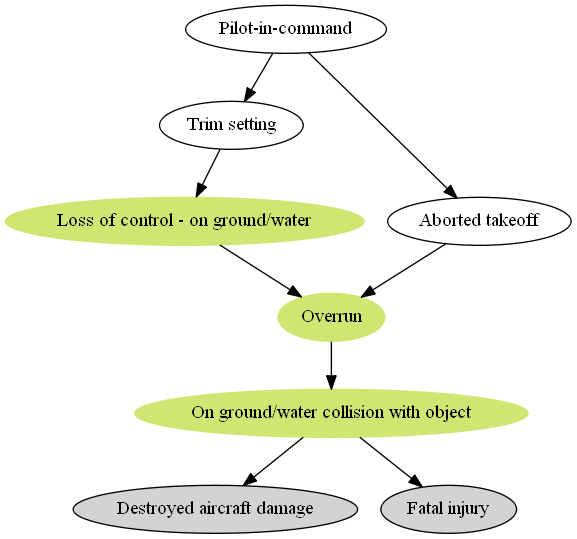

In [61]:
dictAircraftDamage = {'MINR': 'Minor', 'DEST': 'Destroyed', 'NONE': 'None', 'UNK': 'Unknown', 'SUBS': 'Substantial'}
dictEdges = {}
g1 = buildOneGraphRep(sample_ev_ID)
drawImage(g1)
#drawPDF(g1, 'test')

#### Add all the connections for accidents before 2006

In [62]:
dictEdges = {}
for sample_ev_ID in ev_ID:
    #print (sample_ev_ID)
    buildOneGraphRep(sample_ev_ID)

In [63]:
df_records

eventId                               from  \
0      20001213X29335                     Pilotincommand   
1      20001213X29335                     Pilotincommand   
2      20001213X29335                        Trimsetting   
3      20001213X29335                     Abortedtakeoff   
4      20001213X29335         Lossofcontrolongroundwater   
...               ...                                ...   
11261  20001213X32836                   DecisionheightDH   
11262  20001213X32836                           Goaround   
11263  20001213X32836       Inflightencounterwithweather   
11264  20001213X32836  Inflightcollisionwithterrainwater   
11265  20001213X32836  Inflightcollisionwithterrainwater   

                                      to  
0                            Trimsetting  
1                         Abortedtakeoff  
2             Lossofcontrolongroundwater  
3                                Overrun  
4                                Overrun  
...                                  ...  
11261  Inflightcollisionwithterrainwater  
11262  Inflightcollisionwithterrainwater  
11263  Inflightcollisionwithterrainwater  
11264                Minoraircraftdamage  
11265                           Noinjury  

[11266 rows x 3 columns]

In [64]:
setCauses = set(df_records['from'].values)

dictElement = {}

for cause in setCauses:
    outcomes = set(df_records[(df_records['from'] == cause)]['to'].values)
    
    for outcome in outcomes:
        #print ('no causes: ', no_causes)

        key = cause + '->' + outcome

        jointEvents = set(df_records[(df_records['to'] == outcome) & (df_records['from'] == cause)]['eventId'].values)
        denominator = set(df_records[(df_records['from'] == cause) | (df_records['to'] == cause)]['eventId'].values)

        if key not in dictElement.keys():
            dictElement[key] = len(jointEvents)/len(denominator)
            
            if dictElement[key] == 1:
                dictElement[key] = dictElement[key] * 0.8

In [65]:
dictElement

{'Fatiguechronic->Ongroundwatercollisionwithobject': 0.8,
 'Miscellaneousequipmentfurnishingstowbar->Ongroundwatercollisionwithobject': 0.5,
 'Miscellaneousequipmentfurnishingstowbar->Miscellaneousother': 0.5,
 'Constantspeeddrive->Airframecomponentsystemfailuremalfunction': 0.8,
 'Airportequipmentgroundsupport->Ongroundwatercollisionwithobject': 0.5,
 'Airportequipmentgroundsupport->Miscellaneousother': 0.3333333333333333,
 'Airportequipmentgroundsupport->Airframecomponentsystemfailuremalfunction': 0.16666666666666666,
 'Navigationcomputer->Ongroundwatercollisionwithobject': 0.8,
 'FAAairwaysfacilitypersonnel->Facilityinadequateinstrumentlocation': 0.8,
 'Engineassemblypiston->Lossofenginepower': 0.8,
 'Visualauralperception->Ongroundwatercollisionwithterrainwater': 0.07142857142857142,
 'Visualauralperception->Ongroundwatercollisionwithobject': 0.21428571428571427,
 'Visualauralperception->Miscellaneousother': 0.21428571428571427,
 'Visualauralperception->Inflightcollisionwithobject'

In [66]:
setCauses

{'ATCclearance',
 'ATCpersonnelAirRouteTrafficControlCenterARTCC',
 'ATCpersonnelFlightServiceStationFSS',
 'ATCpersonneldepartureapproach',
 'ATCpersonnellocalgroundclearancedelivery',
 'ATCpersonnelnonFAA',
 'ATCpersonnelsupervisor',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Accessorydriveassembly',
 'Accessorydriveassemblydrivegear',
 'Accessorydriveassemblydriveshaft',
 'Accessorydriveassemblyextensionunit',
 'Accessorydriveassemblyexternalshaftbearing',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Airconditioningheatingpressurization',
 'Airconditioningheatingpressurizationcabintemperaturecontrol',
 'Airconditioningheatingpressurizationcontrolindicator',
 'Airconditioningheatingpressurizationfreonsystem',
 'Airconditioningheatingpressurizationoutflowvalve',
 'Airconditioningheatingpressurizationpressureregulator',
 'Airconditioningheatingpressurizationsafetyvalve',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Ai

In [67]:
dictEdges

{'Electricalsystemelectricwiring->Fire': 9,
 'Fire->Minoraircraftdamage': 52,
 'Fire->Noinjury': 61,
 'Fuelsystemlinefitting->Fire': 2,
 'Fire->Lossofenginepowerpartialmechanicalfailuremalfunction': 1,
 'Lossofenginepowerpartialmechanicalfailuremalfunction->Forcedlanding': 3,
 'Forcedlanding->Minoraircraftdamage': 6,
 'Forcedlanding->Noinjury': 12,
 'Companymaintenancepersonnel->Maintenanceinspection': 45,
 'Companymaintenancepersonnel->MaintenancecompliancewithairworthinessdirectiveAD': 2,
 'Landinggearmaingearattachment->Airframecomponentsystemfailuremalfunction': 5,
 'Maintenanceinspection->Airframecomponentsystemfailuremalfunction': 40,
 'MaintenancecompliancewithairworthinessdirectiveAD->Airframecomponentsystemfailuremalfunction': 2,
 'Airframecomponentsystemfailuremalfunction->Minoraircraftdamage': 131,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Pilotincommand->Proceduresdirectives': 39,
 'Companyoperatormanagement->Evacuation': 1,
 'Doorinspection->Airframeco

In [68]:
len(dictElement)

3158

In [69]:
len(dictEdges)

3158

#### Construct a dataframe to represent all the links in the network

In [70]:
lst = ['name', 'fromID', 'toID', 'count']
df_edges = pd.DataFrame(columns = lst)

for key, value in dictEdges.items():
    name = key
    fromID, toID = str(key).split('->')
    count = dictElement[key]
    
    row = {'name': key, 'fromID': fromID, 'toID': toID, 'count': count}
    df_edges = df_edges.append(row, ignore_index=True)

In [71]:
df_records[df_records['to'] == 'Inflightencounterwithweather']

eventId                           from  \
32     20010910X01911               Weathercondition   
33     20010910X01911  Flightintoknownadverseweather   
79     20001213X33518               Weathercondition   
80     20001213X33518                       Seatbelt   
81     20001213X33518       Unsafehazardouscondition   
...               ...                            ...   
11116  20020917X03898           Proceduresdirectives   
11117  20020917X03898             Weatherobservation   
11160  20001213X32134               Weathercondition   
11257  20001213X32836               Weathercondition   
11258  20001213X32836                Plannedapproach   

                                 to  
32     Inflightencounterwithweather  
33     Inflightencounterwithweather  
79     Inflightencounterwithweather  
80     Inflightencounterwithweather  
81     Inflightencounterwithweather  
...                             ...  
11116  Inflightencounterwithweather  
11117  Inflightencounterwithweather  
11160  Inflightencounterwithweather  
11257  Inflightencounterwithweather  
11258  Inflightencounterwithweather  

[417 rows x 3 columns]

In [72]:
parentInfo = df_edges[df_edges['toID'] == 'Inflightencounterwithweather'][['fromID', 'count']].values
sorted(parentInfo, key=lambda x: x[1], reverse = True)

[array(['Flightintoadverseweather', 0.9230769230769231], dtype=object),
 array(['Seatbeltsign', 0.8571428571428571], dtype=object),
 array(['Hazardousweatheradvisory', 0.8333333333333334], dtype=object),
 array(['Passengerbriefing', 0.8333333333333334], dtype=object),
 array(['Seatbelt', 0.8292682926829268], dtype=object),
 array(['Preflightbriefingservice', 0.8], dtype=object),
 array(['Weatherforecast', 0.8], dtype=object),
 array(['Pressure', 0.8], dtype=object),
 array(['Meteorologicalservice', 0.8], dtype=object),
 array(['Miscellaneousequipmentfurnishingsfirstaidequipment', 0.8],
       dtype=object),
 array(['Flightcontrolelevatorsurface', 0.8], dtype=object),
 array(['Inflightweatheradvisories', 0.8], dtype=object),
 array(['Weatherradar', 0.8], dtype=object),
 array(['Flightnavigationinstrumentsairspeedindicator', 0.8], dtype=object),
 array(['Flightintoknownadverseweather', 0.6666666666666666], dtype=object),
 array(['Crewgroupbriefing', 0.625], dtype=object),
 array(['Weathe

### Construct Bayesian network with PySMILE library

#### Construct XDSL file to be fed into PySMILE

In [156]:
import numpy as np

def CPT_estimation(x, a, b):
    return (1 + np.exp(a+b))/(1 + np.exp(a/x + b))

def obj(x, normProb, probs):
    diff = (1 + np.exp(x[0]+x[1]))/(1 + np.exp(x[0]/normProb + x[1])) - probs
    return np.sum(diff**2)

from scipy.optimize import minimize

In [157]:
def binaryConversion(value, n):
    m = eval('"' + "{0:0" + str(n) + "b}" + '"').format(value) ## binary representation
    characters = [int(char) for char in str(m)]
    res = np.array(characters)
    return res

In [206]:
dictParameter = {}

def constructCPT(parentInfo, toID):
    n = parentInfo.shape[0]
    count = parentInfo[:, 1]
    
    #print (count)

    start = 2**n - 1
    
    CPT = []
    lambda_val = sum(count) - 1
    for i in range(start, -1, -1):
        scheme = binaryConversion(i, n)
        
        if sum(scheme) == 1:
            Yes_prob = np.sum(np.multiply(scheme, count))
        else:
            totalContribution = np.sum(count)
            normContribution = count/totalContribution
            
            normContribution = np.array([min(normContribution), max(normContribution)])
            probs = np.array([min(count), max(count)])
            
            if toID not in dictParameter.keys():
                ## calibrate the parameters
                x_0 = [-1, 1]
                res = minimize(obj, x_0, args = (normContribution, probs), method='Powell', tol=1e-6)

                a = res.x[0]
                b = res.x[1]
                
                dictParameter[toID] = [a, b]
                
                print ('Obj: ', res.fun, 'a:', a, 'b: ', b)
            else:
                a = dictParameter[toID][0]
                b = dictParameter[toID][1]
            
            CPT_contribution = np.sum(np.multiply(scheme, count))/totalContribution
            Yes_prob = CPT_estimation(CPT_contribution, a, b)
            
            assert Yes_prob > max(np.multiply(scheme, count))
            
        No_prob = 1 - Yes_prob
        
        CPT.append(Yes_prob)
        CPT.append(No_prob)
    
    return CPT

def occurrenceTimes(toID):
    toID = set(df_records[df_records['to'] == toID]['eventId'].values)
    fromID = set(df_records[df_records['from'] == toID]['eventId'].values)
    return len(toID.union(fromID))

def occurrenceTimesFromID(fromID):
    return len(set(df_records[df_records['from'] == fromID]['eventId'].values))

In [207]:
parentInfo = df_edges[df_edges['toID'] == 'Fire'][['fromID', 'count']].values
constructCPT(parentInfo, 'Fire')

38685626227668133590597631
Obj:  7.71604938271605e-06 a: 0.008689287594389758 b:  1.0094448257845618
38685626227668133590597630
38685626227668133590597629
38685626227668133590597628
38685626227668133590597627
38685626227668133590597626
38685626227668133590597625
38685626227668133590597624
38685626227668133590597623
38685626227668133590597622
38685626227668133590597621
38685626227668133590597620
38685626227668133590597619
38685626227668133590597618
38685626227668133590597617
38685626227668133590597616
38685626227668133590597615
38685626227668133590597614
38685626227668133590597613
38685626227668133590597612
38685626227668133590597611
38685626227668133590597610
38685626227668133590597609
38685626227668133590597608
38685626227668133590597607
38685626227668133590597606
38685626227668133590597605
38685626227668133590597604
38685626227668133590597603
38685626227668133590597602
38685626227668133590597601
38685626227668133590597600
38685626227668133590597599
38685626227668133590597598
38685626

38685626227668133590596759
38685626227668133590596758
38685626227668133590596757
38685626227668133590596756
38685626227668133590596755
38685626227668133590596754
38685626227668133590596753
38685626227668133590596752
38685626227668133590596751
38685626227668133590596750
38685626227668133590596749
38685626227668133590596748
38685626227668133590596747
38685626227668133590596746
38685626227668133590596745
38685626227668133590596744
38685626227668133590596743
38685626227668133590596742
38685626227668133590596741
38685626227668133590596740
38685626227668133590596739
38685626227668133590596738
38685626227668133590596737
38685626227668133590596736
38685626227668133590596735
38685626227668133590596734
38685626227668133590596733
38685626227668133590596732
38685626227668133590596731
38685626227668133590596730
38685626227668133590596729
38685626227668133590596728
38685626227668133590596727
38685626227668133590596726
38685626227668133590596725
38685626227668133590596724
38685626227668133590596723
3

38685626227668133590595868
38685626227668133590595867
38685626227668133590595866
38685626227668133590595865
38685626227668133590595864
38685626227668133590595863
38685626227668133590595862
38685626227668133590595861
38685626227668133590595860
38685626227668133590595859
38685626227668133590595858
38685626227668133590595857
38685626227668133590595856
38685626227668133590595855
38685626227668133590595854
38685626227668133590595853
38685626227668133590595852
38685626227668133590595851
38685626227668133590595850
38685626227668133590595849
38685626227668133590595848
38685626227668133590595847
38685626227668133590595846
38685626227668133590595845
38685626227668133590595844
38685626227668133590595843
38685626227668133590595842
38685626227668133590595841
38685626227668133590595840
38685626227668133590595839
38685626227668133590595838
38685626227668133590595837
38685626227668133590595836
38685626227668133590595835
38685626227668133590595834
38685626227668133590595833
38685626227668133590595832
3

38685626227668133590594981
38685626227668133590594980
38685626227668133590594979
38685626227668133590594978
38685626227668133590594977
38685626227668133590594976
38685626227668133590594975
38685626227668133590594974
38685626227668133590594973
38685626227668133590594972
38685626227668133590594971
38685626227668133590594970
38685626227668133590594969
38685626227668133590594968
38685626227668133590594967
38685626227668133590594966
38685626227668133590594965
38685626227668133590594964
38685626227668133590594963
38685626227668133590594962
38685626227668133590594961
38685626227668133590594960
38685626227668133590594959
38685626227668133590594958
38685626227668133590594957
38685626227668133590594956
38685626227668133590594955
38685626227668133590594954
38685626227668133590594953
38685626227668133590594952
38685626227668133590594951
38685626227668133590594950
38685626227668133590594949
38685626227668133590594948
38685626227668133590594947
38685626227668133590594946
38685626227668133590594945
3

38685626227668133590594089
38685626227668133590594088
38685626227668133590594087
38685626227668133590594086
38685626227668133590594085
38685626227668133590594084
38685626227668133590594083
38685626227668133590594082
38685626227668133590594081
38685626227668133590594080
38685626227668133590594079
38685626227668133590594078
38685626227668133590594077
38685626227668133590594076
38685626227668133590594075
38685626227668133590594074
38685626227668133590594073
38685626227668133590594072
38685626227668133590594071
38685626227668133590594070
38685626227668133590594069
38685626227668133590594068
38685626227668133590594067
38685626227668133590594066
38685626227668133590594065
38685626227668133590594064
38685626227668133590594063
38685626227668133590594062
38685626227668133590594061
38685626227668133590594060
38685626227668133590594059
38685626227668133590594058
38685626227668133590594057
38685626227668133590594056
38685626227668133590594055
38685626227668133590594054
38685626227668133590594053
3

38685626227668133590593177
38685626227668133590593176
38685626227668133590593175
38685626227668133590593174
38685626227668133590593173
38685626227668133590593172
38685626227668133590593171
38685626227668133590593170
38685626227668133590593169
38685626227668133590593168
38685626227668133590593167
38685626227668133590593166
38685626227668133590593165
38685626227668133590593164
38685626227668133590593163
38685626227668133590593162
38685626227668133590593161
38685626227668133590593160
38685626227668133590593159
38685626227668133590593158
38685626227668133590593157
38685626227668133590593156
38685626227668133590593155
38685626227668133590593154
38685626227668133590593153
38685626227668133590593152
38685626227668133590593151
38685626227668133590593150
38685626227668133590593149
38685626227668133590593148
38685626227668133590593147
38685626227668133590593146
38685626227668133590593145
38685626227668133590593144
38685626227668133590593143
38685626227668133590593142
38685626227668133590593141
3

38685626227668133590592331
38685626227668133590592330
38685626227668133590592329
38685626227668133590592328
38685626227668133590592327
38685626227668133590592326
38685626227668133590592325
38685626227668133590592324
38685626227668133590592323
38685626227668133590592322
38685626227668133590592321
38685626227668133590592320
38685626227668133590592319
38685626227668133590592318
38685626227668133590592317
38685626227668133590592316
38685626227668133590592315
38685626227668133590592314
38685626227668133590592313
38685626227668133590592312
38685626227668133590592311
38685626227668133590592310
38685626227668133590592309
38685626227668133590592308
38685626227668133590592307
38685626227668133590592306
38685626227668133590592305
38685626227668133590592304
38685626227668133590592303
38685626227668133590592302
38685626227668133590592301
38685626227668133590592300
38685626227668133590592299
38685626227668133590592298
38685626227668133590592297
38685626227668133590592296
38685626227668133590592295
3

38685626227668133590591493
38685626227668133590591492
38685626227668133590591491
38685626227668133590591490
38685626227668133590591489
38685626227668133590591488
38685626227668133590591487
38685626227668133590591486
38685626227668133590591485
38685626227668133590591484
38685626227668133590591483
38685626227668133590591482
38685626227668133590591481
38685626227668133590591480
38685626227668133590591479
38685626227668133590591478
38685626227668133590591477
38685626227668133590591476
38685626227668133590591475
38685626227668133590591474
38685626227668133590591473
38685626227668133590591472
38685626227668133590591471
38685626227668133590591470
38685626227668133590591469
38685626227668133590591468
38685626227668133590591467
38685626227668133590591466
38685626227668133590591465
38685626227668133590591464
38685626227668133590591463
38685626227668133590591462
38685626227668133590591461
38685626227668133590591460
38685626227668133590591459
38685626227668133590591458
38685626227668133590591457
3

38685626227668133590590648
38685626227668133590590647
38685626227668133590590646
38685626227668133590590645
38685626227668133590590644
38685626227668133590590643
38685626227668133590590642
38685626227668133590590641
38685626227668133590590640
38685626227668133590590639
38685626227668133590590638
38685626227668133590590637
38685626227668133590590636
38685626227668133590590635
38685626227668133590590634
38685626227668133590590633
38685626227668133590590632
38685626227668133590590631
38685626227668133590590630
38685626227668133590590629
38685626227668133590590628
38685626227668133590590627
38685626227668133590590626
38685626227668133590590625
38685626227668133590590624
38685626227668133590590623
38685626227668133590590622
38685626227668133590590621
38685626227668133590590620
38685626227668133590590619
38685626227668133590590618
38685626227668133590590617
38685626227668133590590616
38685626227668133590590615
38685626227668133590590614
38685626227668133590590613
38685626227668133590590612
3

38685626227668133590589808
38685626227668133590589807
38685626227668133590589806
38685626227668133590589805
38685626227668133590589804
38685626227668133590589803
38685626227668133590589802
38685626227668133590589801
38685626227668133590589800
38685626227668133590589799
38685626227668133590589798
38685626227668133590589797
38685626227668133590589796
38685626227668133590589795
38685626227668133590589794
38685626227668133590589793
38685626227668133590589792
38685626227668133590589791
38685626227668133590589790
38685626227668133590589789
38685626227668133590589788
38685626227668133590589787
38685626227668133590589786
38685626227668133590589785
38685626227668133590589784
38685626227668133590589783
38685626227668133590589782
38685626227668133590589781
38685626227668133590589780
38685626227668133590589779
38685626227668133590589778
38685626227668133590589777
38685626227668133590589776
38685626227668133590589775
38685626227668133590589774
38685626227668133590589773
38685626227668133590589772
3

38685626227668133590588946
38685626227668133590588945
38685626227668133590588944
38685626227668133590588943
38685626227668133590588942
38685626227668133590588941
38685626227668133590588940
38685626227668133590588939
38685626227668133590588938
38685626227668133590588937
38685626227668133590588936
38685626227668133590588935
38685626227668133590588934
38685626227668133590588933
38685626227668133590588932
38685626227668133590588931
38685626227668133590588930
38685626227668133590588929
38685626227668133590588928
38685626227668133590588927
38685626227668133590588926
38685626227668133590588925
38685626227668133590588924
38685626227668133590588923
38685626227668133590588922
38685626227668133590588921
38685626227668133590588920
38685626227668133590588919
38685626227668133590588918
38685626227668133590588917
38685626227668133590588916
38685626227668133590588915
38685626227668133590588914
38685626227668133590588913
38685626227668133590588912
38685626227668133590588911
38685626227668133590588910
3

38685626227668133590588057
38685626227668133590588056
38685626227668133590588055
38685626227668133590588054
38685626227668133590588053
38685626227668133590588052
38685626227668133590588051
38685626227668133590588050
38685626227668133590588049
38685626227668133590588048
38685626227668133590588047
38685626227668133590588046
38685626227668133590588045
38685626227668133590588044
38685626227668133590588043
38685626227668133590588042
38685626227668133590588041
38685626227668133590588040
38685626227668133590588039
38685626227668133590588038
38685626227668133590588037
38685626227668133590588036
38685626227668133590588035
38685626227668133590588034
38685626227668133590588033
38685626227668133590588032
38685626227668133590588031
38685626227668133590588030
38685626227668133590588029
38685626227668133590588028
38685626227668133590588027
38685626227668133590588026
38685626227668133590588025
38685626227668133590588024
38685626227668133590588023
38685626227668133590588022
38685626227668133590588021
3

38685626227668133590587191
38685626227668133590587190
38685626227668133590587189
38685626227668133590587188
38685626227668133590587187
38685626227668133590587186
38685626227668133590587185
38685626227668133590587184
38685626227668133590587183
38685626227668133590587182
38685626227668133590587181
38685626227668133590587180
38685626227668133590587179
38685626227668133590587178
38685626227668133590587177
38685626227668133590587176
38685626227668133590587175
38685626227668133590587174
38685626227668133590587173
38685626227668133590587172
38685626227668133590587171
38685626227668133590587170
38685626227668133590587169
38685626227668133590587168
38685626227668133590587167
38685626227668133590587166
38685626227668133590587165
38685626227668133590587164
38685626227668133590587163
38685626227668133590587162
38685626227668133590587161
38685626227668133590587160
38685626227668133590587159
38685626227668133590587158
38685626227668133590587157
38685626227668133590587156
38685626227668133590587155
3

38685626227668133590586309
38685626227668133590586308
38685626227668133590586307
38685626227668133590586306
38685626227668133590586305
38685626227668133590586304
38685626227668133590586303
38685626227668133590586302
38685626227668133590586301
38685626227668133590586300
38685626227668133590586299
38685626227668133590586298
38685626227668133590586297
38685626227668133590586296
38685626227668133590586295
38685626227668133590586294
38685626227668133590586293
38685626227668133590586292
38685626227668133590586291
38685626227668133590586290
38685626227668133590586289
38685626227668133590586288
38685626227668133590586287
38685626227668133590586286
38685626227668133590586285
38685626227668133590586284
38685626227668133590586283
38685626227668133590586282
38685626227668133590586281
38685626227668133590586280
38685626227668133590586279
38685626227668133590586278
38685626227668133590586277
38685626227668133590586276
38685626227668133590586275
38685626227668133590586274
38685626227668133590586273
3

38685626227668133590585451
38685626227668133590585450
38685626227668133590585449
38685626227668133590585448
38685626227668133590585447
38685626227668133590585446
38685626227668133590585445
38685626227668133590585444
38685626227668133590585443
38685626227668133590585442
38685626227668133590585441
38685626227668133590585440
38685626227668133590585439
38685626227668133590585438
38685626227668133590585437
38685626227668133590585436
38685626227668133590585435
38685626227668133590585434
38685626227668133590585433
38685626227668133590585432
38685626227668133590585431
38685626227668133590585430
38685626227668133590585429
38685626227668133590585428
38685626227668133590585427
38685626227668133590585426
38685626227668133590585425
38685626227668133590585424
38685626227668133590585423
38685626227668133590585422
38685626227668133590585421
38685626227668133590585420
38685626227668133590585419
38685626227668133590585418
38685626227668133590585417
38685626227668133590585416
38685626227668133590585415
3

38685626227668133590584542
38685626227668133590584541
38685626227668133590584540
38685626227668133590584539
38685626227668133590584538
38685626227668133590584537
38685626227668133590584536
38685626227668133590584535
38685626227668133590584534
38685626227668133590584533
38685626227668133590584532
38685626227668133590584531
38685626227668133590584530
38685626227668133590584529
38685626227668133590584528
38685626227668133590584527
38685626227668133590584526
38685626227668133590584525
38685626227668133590584524
38685626227668133590584523
38685626227668133590584522
38685626227668133590584521
38685626227668133590584520
38685626227668133590584519
38685626227668133590584518
38685626227668133590584517
38685626227668133590584516
38685626227668133590584515
38685626227668133590584514
38685626227668133590584513
38685626227668133590584512
38685626227668133590584511
38685626227668133590584510
38685626227668133590584509
38685626227668133590584508
38685626227668133590584507
38685626227668133590584506
3

38685626227668133590583684
38685626227668133590583683
38685626227668133590583682
38685626227668133590583681
38685626227668133590583680
38685626227668133590583679
38685626227668133590583678
38685626227668133590583677
38685626227668133590583676
38685626227668133590583675
38685626227668133590583674
38685626227668133590583673
38685626227668133590583672
38685626227668133590583671
38685626227668133590583670
38685626227668133590583669
38685626227668133590583668
38685626227668133590583667
38685626227668133590583666
38685626227668133590583665
38685626227668133590583664
38685626227668133590583663
38685626227668133590583662
38685626227668133590583661
38685626227668133590583660
38685626227668133590583659
38685626227668133590583658
38685626227668133590583657
38685626227668133590583656
38685626227668133590583655
38685626227668133590583654
38685626227668133590583653
38685626227668133590583652
38685626227668133590583651
38685626227668133590583650
38685626227668133590583649
38685626227668133590583648
3

38685626227668133590582815
38685626227668133590582814
38685626227668133590582813
38685626227668133590582812
38685626227668133590582811
38685626227668133590582810
38685626227668133590582809
38685626227668133590582808
38685626227668133590582807
38685626227668133590582806
38685626227668133590582805
38685626227668133590582804
38685626227668133590582803
38685626227668133590582802
38685626227668133590582801
38685626227668133590582800
38685626227668133590582799
38685626227668133590582798
38685626227668133590582797
38685626227668133590582796
38685626227668133590582795
38685626227668133590582794
38685626227668133590582793
38685626227668133590582792
38685626227668133590582791
38685626227668133590582790
38685626227668133590582789
38685626227668133590582788
38685626227668133590582787
38685626227668133590582786
38685626227668133590582785
38685626227668133590582784
38685626227668133590582783
38685626227668133590582782
38685626227668133590582781
38685626227668133590582780
38685626227668133590582779
3

38685626227668133590581936
38685626227668133590581935
38685626227668133590581934
38685626227668133590581933
38685626227668133590581932
38685626227668133590581931
38685626227668133590581930
38685626227668133590581929
38685626227668133590581928
38685626227668133590581927
38685626227668133590581926
38685626227668133590581925
38685626227668133590581924
38685626227668133590581923
38685626227668133590581922
38685626227668133590581921
38685626227668133590581920
38685626227668133590581919
38685626227668133590581918
38685626227668133590581917
38685626227668133590581916
38685626227668133590581915
38685626227668133590581914
38685626227668133590581913
38685626227668133590581912
38685626227668133590581911
38685626227668133590581910
38685626227668133590581909
38685626227668133590581908
38685626227668133590581907
38685626227668133590581906
38685626227668133590581905
38685626227668133590581904
38685626227668133590581903
38685626227668133590581902
38685626227668133590581901
38685626227668133590581900
3

38685626227668133590581055
38685626227668133590581054
38685626227668133590581053
38685626227668133590581052
38685626227668133590581051
38685626227668133590581050
38685626227668133590581049
38685626227668133590581048
38685626227668133590581047
38685626227668133590581046
38685626227668133590581045
38685626227668133590581044
38685626227668133590581043
38685626227668133590581042
38685626227668133590581041
38685626227668133590581040
38685626227668133590581039
38685626227668133590581038
38685626227668133590581037
38685626227668133590581036
38685626227668133590581035
38685626227668133590581034
38685626227668133590581033
38685626227668133590581032
38685626227668133590581031
38685626227668133590581030
38685626227668133590581029
38685626227668133590581028
38685626227668133590581027
38685626227668133590581026
38685626227668133590581025
38685626227668133590581024
38685626227668133590581023
38685626227668133590581022
38685626227668133590581021
38685626227668133590581020
38685626227668133590581019
3

38685626227668133590580205
38685626227668133590580204
38685626227668133590580203
38685626227668133590580202
38685626227668133590580201
38685626227668133590580200
38685626227668133590580199
38685626227668133590580198
38685626227668133590580197
38685626227668133590580196
38685626227668133590580195
38685626227668133590580194
38685626227668133590580193
38685626227668133590580192
38685626227668133590580191
38685626227668133590580190
38685626227668133590580189
38685626227668133590580188
38685626227668133590580187
38685626227668133590580186
38685626227668133590580185
38685626227668133590580184
38685626227668133590580183
38685626227668133590580182
38685626227668133590580181
38685626227668133590580180
38685626227668133590580179
38685626227668133590580178
38685626227668133590580177
38685626227668133590580176
38685626227668133590580175
38685626227668133590580174
38685626227668133590580173
38685626227668133590580172
38685626227668133590580171
38685626227668133590580170
38685626227668133590580169
3

38685626227668133590579336
38685626227668133590579335
38685626227668133590579334
38685626227668133590579333
38685626227668133590579332
38685626227668133590579331
38685626227668133590579330
38685626227668133590579329
38685626227668133590579328
38685626227668133590579327
38685626227668133590579326
38685626227668133590579325
38685626227668133590579324
38685626227668133590579323
38685626227668133590579322
38685626227668133590579321
38685626227668133590579320
38685626227668133590579319
38685626227668133590579318
38685626227668133590579317
38685626227668133590579316
38685626227668133590579315
38685626227668133590579314
38685626227668133590579313
38685626227668133590579312
38685626227668133590579311
38685626227668133590579310
38685626227668133590579309
38685626227668133590579308
38685626227668133590579307
38685626227668133590579306
38685626227668133590579305
38685626227668133590579304
38685626227668133590579303
38685626227668133590579302
38685626227668133590579301
38685626227668133590579300
3

38685626227668133590578442
38685626227668133590578441
38685626227668133590578440
38685626227668133590578439
38685626227668133590578438
38685626227668133590578437
38685626227668133590578436
38685626227668133590578435
38685626227668133590578434
38685626227668133590578433
38685626227668133590578432
38685626227668133590578431
38685626227668133590578430
38685626227668133590578429
38685626227668133590578428
38685626227668133590578427
38685626227668133590578426
38685626227668133590578425
38685626227668133590578424
38685626227668133590578423
38685626227668133590578422
38685626227668133590578421
38685626227668133590578420
38685626227668133590578419
38685626227668133590578418
38685626227668133590578417
38685626227668133590578416
38685626227668133590578415
38685626227668133590578414
38685626227668133590578413
38685626227668133590578412
38685626227668133590578411
38685626227668133590578410
38685626227668133590578409
38685626227668133590578408
38685626227668133590578407
38685626227668133590578406
3

38685626227668133590577555
38685626227668133590577554
38685626227668133590577553
38685626227668133590577552
38685626227668133590577551
38685626227668133590577550
38685626227668133590577549
38685626227668133590577548
38685626227668133590577547
38685626227668133590577546
38685626227668133590577545
38685626227668133590577544
38685626227668133590577543
38685626227668133590577542
38685626227668133590577541
38685626227668133590577540
38685626227668133590577539
38685626227668133590577538
38685626227668133590577537
38685626227668133590577536
38685626227668133590577535
38685626227668133590577534
38685626227668133590577533
38685626227668133590577532
38685626227668133590577531
38685626227668133590577530
38685626227668133590577529
38685626227668133590577528
38685626227668133590577527
38685626227668133590577526
38685626227668133590577525
38685626227668133590577524
38685626227668133590577523
38685626227668133590577522
38685626227668133590577521
38685626227668133590577520
38685626227668133590577519
3

38685626227668133590576675
38685626227668133590576674
38685626227668133590576673
38685626227668133590576672
38685626227668133590576671
38685626227668133590576670
38685626227668133590576669
38685626227668133590576668
38685626227668133590576667
38685626227668133590576666
38685626227668133590576665
38685626227668133590576664
38685626227668133590576663
38685626227668133590576662
38685626227668133590576661
38685626227668133590576660
38685626227668133590576659
38685626227668133590576658
38685626227668133590576657
38685626227668133590576656
38685626227668133590576655
38685626227668133590576654
38685626227668133590576653
38685626227668133590576652
38685626227668133590576651
38685626227668133590576650
38685626227668133590576649
38685626227668133590576648
38685626227668133590576647
38685626227668133590576646
38685626227668133590576645
38685626227668133590576644
38685626227668133590576643
38685626227668133590576642
38685626227668133590576641
38685626227668133590576640
38685626227668133590576639
3

38685626227668133590575790
38685626227668133590575789
38685626227668133590575788
38685626227668133590575787
38685626227668133590575786
38685626227668133590575785
38685626227668133590575784
38685626227668133590575783
38685626227668133590575782
38685626227668133590575781
38685626227668133590575780
38685626227668133590575779
38685626227668133590575778
38685626227668133590575777
38685626227668133590575776
38685626227668133590575775
38685626227668133590575774
38685626227668133590575773
38685626227668133590575772
38685626227668133590575771
38685626227668133590575770
38685626227668133590575769
38685626227668133590575768
38685626227668133590575767
38685626227668133590575766
38685626227668133590575765
38685626227668133590575764
38685626227668133590575763
38685626227668133590575762
38685626227668133590575761
38685626227668133590575760
38685626227668133590575759
38685626227668133590575758
38685626227668133590575757
38685626227668133590575756
38685626227668133590575755
38685626227668133590575754
3

KeyboardInterrupt: 

##### Load the license

In [75]:
import pysmile

## load license
pysmile.License((
    b"SMILE LICENSE cd06be93 97a7a599 29f4a47f "
    b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
    b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
    b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
    b"SOFTWARE LICENSING AGREEMENT. "
    b"Serial #: ckw9n4254hey3kiszvj6n5k0b "
    b"Issued for: Xiaoge Zhang (zxgcqupt@gmail.com) "
    b"Academic institution: Vanderbilt University "
    b"Valid until: 2020-03-22 "
    b"Issued by BayesFusion activation server"
    ),[
    0xf5,0xdc,0x56,0x91,0x01,0x05,0xdb,0x8d,0xf0,0xbf,0x21,0xe9,0x58,0x09,0x41,0x79,
    0x1f,0xd8,0xd4,0xb3,0x0a,0xaf,0x09,0xad,0xf2,0x41,0x58,0x93,0xc2,0x51,0x28,0xb0,
    0x8d,0xad,0x69,0x38,0x8d,0x82,0x43,0x01,0xca,0xd9,0xd3,0xa2,0x5c,0x98,0xe2,0x9a,
    0x99,0xbf,0xa4,0x17,0x4f,0xbb,0xd6,0x9a,0x72,0xf4,0x23,0xf5,0xed,0x94,0x4b,0x8e])

##### Define the denominator to represent the number of flights from 1982 to 2006

In [124]:
dictEdges

{'Electricalsystemelectricwiring->Fire': 9,
 'Fire->Minoraircraftdamage': 52,
 'Fire->Noinjury': 61,
 'Fuelsystemlinefitting->Fire': 2,
 'Fire->Lossofenginepowerpartialmechanicalfailuremalfunction': 1,
 'Lossofenginepowerpartialmechanicalfailuremalfunction->Forcedlanding': 3,
 'Forcedlanding->Minoraircraftdamage': 6,
 'Forcedlanding->Noinjury': 12,
 'Companymaintenancepersonnel->Maintenanceinspection': 45,
 'Companymaintenancepersonnel->MaintenancecompliancewithairworthinessdirectiveAD': 2,
 'Landinggearmaingearattachment->Airframecomponentsystemfailuremalfunction': 5,
 'Maintenanceinspection->Airframecomponentsystemfailuremalfunction': 40,
 'MaintenancecompliancewithairworthinessdirectiveAD->Airframecomponentsystemfailuremalfunction': 2,
 'Airframecomponentsystemfailuremalfunction->Minoraircraftdamage': 131,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Pilotincommand->Proceduresdirectives': 39,
 'Companyoperatormanagement->Evacuation': 1,
 'Doorinspection->Airframeco

In [125]:
dictEdges.items()

dict_items([('Electricalsystemelectricwiring->Fire', 9), ('Fire->Minoraircraftdamage', 52), ('Fire->Noinjury', 61), ('Fuelsystemlinefitting->Fire', 2), ('Fire->Lossofenginepowerpartialmechanicalfailuremalfunction', 1), ('Lossofenginepowerpartialmechanicalfailuremalfunction->Forcedlanding', 3), ('Forcedlanding->Minoraircraftdamage', 6), ('Forcedlanding->Noinjury', 12), ('Companymaintenancepersonnel->Maintenanceinspection', 45), ('Companymaintenancepersonnel->MaintenancecompliancewithairworthinessdirectiveAD', 2), ('Landinggearmaingearattachment->Airframecomponentsystemfailuremalfunction', 5), ('Maintenanceinspection->Airframecomponentsystemfailuremalfunction', 40), ('MaintenancecompliancewithairworthinessdirectiveAD->Airframecomponentsystemfailuremalfunction', 2), ('Airframecomponentsystemfailuremalfunction->Minoraircraftdamage', 131), ('Airframecomponentsystemfailuremalfunction->Noinjury', 231), ('Pilotincommand->Proceduresdirectives', 39), ('Companyoperatormanagement->Evacuation', 1),

In [78]:
maxElements = 12

def searchThreshold(parentInfo):
    threshold = 0
    
    m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    while m > maxElements:
        if m < maxElements:
            threshold -= min(parentInfo[:, 1])
        else:
            threshold += min(parentInfo[:, 1])
   
        m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    if threshold > max(parentInfo[:, 1]):
        threshold = max(parentInfo[:, 1])
    
    return threshold

###### Compute the total number of scheduled flights within USA

In [79]:
departures = pd.read_excel('table_01_37_061019.xlsx')
departures.drop(departures.columns[0], axis=1, inplace= True)

In [80]:
years = departures.iloc[0].index
flights = departures.iloc[0].values

In [81]:
years = [int(i) for i in years]

Text(0, 0.5, 'Scheduled flights')

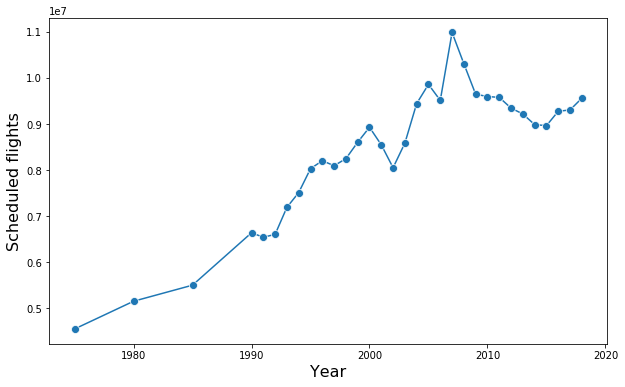

In [82]:
plt.figure(figsize=(10, 6))
sns.lineplot(years, flights, marker = 'o', markersize = 8)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Scheduled flights', fontsize = 16)

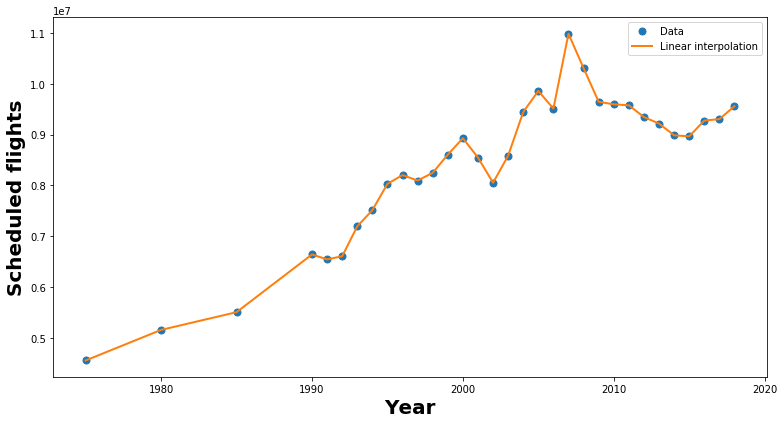

In [83]:
from scipy.interpolate import interp1d

f = interp1d(years, flights)
xnew = np.linspace(1975, 2018, num = 44, endpoint=True)

ax = plt.figure(figsize=(11, 6))
plt.plot(years, flights, 'o', xnew, f(xnew), '-', markersize = 7, linewidth=2)
plt.legend(['Data', 'Linear interpolation'], loc='best')
plt.xlabel('Year', fontsize = 20, fontweight = 'bold')
plt.ylabel('Scheduled flights', fontsize = 20, fontweight = 'bold')
plt.tight_layout()

plt.savefig('departures.pdf')

In [84]:
totalFlights = 0
for i in range(1982, 2007, 1):
    totalFlights += f(i)

In [85]:
totalFlights = round(totalFlights)
print ('The total number of flights from 1982 to 2006 is', totalFlights)

The total number of flights from 1982 to 2006 is 184517128.0


##### Prior probability estimation

In [86]:
set(df_records['to'].values)

{'ATCclearance',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Aircraftequipmentinadequateaircraftcomponent',
 'Aircraftequipmentinadequateaircraftmanuals',
 'Aircraftequipmentinadequateairframe',
 'Aircraftequipmentinadequatecompliancedetermination',
 'Aircraftequipmentinadequatecontrolshapesize',
 'Aircraftequipmentinadequatedesign',
 'Aircraftequipmentinadequatehandlingperformancecapabilities',
 'Aircraftequipmentinadequatestandardrequirement',
 'Aircrafthandling',
 'Aircraftpreflight',
 'Aircraftservice',
 'Aircraftweightandbalance',
 'Airframecomponentsystemfailuremalfunction',
 'Airgroundcommunications',
 'Airport',
 'Airportoperations',
 'Airportsnowremoval',
 'Airspeed',
 'AirspeedliftoffspeedVlof',
 'AirspeedminimumcontrolspeedwiththecriticalengineinoperativeVmc',
 'AirspeedreferenceVref',
 'AirspeedrotationspeedVr',
 'Allavail

In [87]:
event = 'Fire'

In [88]:
eventID_list = set(df_records[(df_records['from'] == event) | (df_records['to'] == event)]['eventId'].values)
totalOccurrences = len(eventID_list)
prob_yes = totalOccurrences/totalFlights
prob_no = 1 - prob_yes
print ('Total occurrences of event %s: %d' % (event, totalOccurrences))
print ('Prior probability of fire occurrence is: ', prob_yes)

Total occurrences of event Fire: 102
Prior probability of fire occurrence is:  5.527942099770814e-07


In [89]:
df_records[df_records['eventId'] == '20050209X00169']

eventId                  from                  to
2003  20050209X00169            Flightcrew       Visuallookout
2004  20050209X00169      Airportpersonnel             Airport
2005  20050209X00169  FAAotherorganization             Airport
2006  20050209X00169         Visuallookout  Miscellaneousother
2007  20050209X00169               Airport  Miscellaneousother
2008  20050209X00169    Miscellaneousother  Noneaircraftdamage
2009  20050209X00169    Miscellaneousother            Noinjury

##### Conditional probability estimation

In [99]:
causes = set(df_records[df_records['to'] == event]['from'].values)

total = 0
maxOccurrence = -1
prob_set = []
for cause in causes:
    cause_occurrences = len(set(df_records[(df_records['from'] == cause) & (df_records['to'] == event)]['eventId'].values))
    
    print ('Cause: ', dictNodeLabel[cause], ', Occurrence: ', cause_occurrences, ', Prob: ', cause_occurrences/totalOccurrences)
    
    total += cause_occurrences/totalOccurrences
    prob_set.append(cause_occurrences/totalOccurrences)
    
    
    if cause_occurrences > maxOccurrence:
        maxOccurrence = cause_occurrences
        
print ('The maximum number of occurrence is', maxOccurrence)

Cause:  Fuel system, nozzle , Occurrence:  2 , Prob:  0.0196078431372549
Cause:  Fuel system, drain , Occurrence:  2 , Prob:  0.0196078431372549
Cause:  Maintenance, service of aircraft/equipment , Occurrence:  2 , Prob:  0.0196078431372549
Cause:  Electrical system, fuse , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Ignition system, exciter , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Electrical system, circuit breaker , Occurrence:  2 , Prob:  0.0196078431372549
Cause:  Aircraft/equipment inadequate, aircraft component , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Condition(s)/step(s) insufficiently defined , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Unknown quantity , Occurrence:  2 , Prob:  0.0196078431372549
Cause:  Passenger compartment light(s) , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Fluid, hydraulic , Occurrence:  1 , Prob:  0.00980392156862745
Cause:  Anti-ice/deice system, windshield , Occurrence:  1 , Prob:  0.0098039215686274

In [101]:
set(prob_set)

{0.00980392156862745,
 0.0196078431372549,
 0.029411764705882353,
 0.0392156862745098,
 0.049019607843137254,
 0.058823529411764705,
 0.08823529411764706,
 0.3137254901960784}

In [102]:
total

1.735294117647057

In [94]:
conditional_prob = maxOccurrence/totalOccurrences

In [96]:
totalOccurrences

102

In [95]:
conditional_prob

0.3137254901960784

##### Generate BN

In [126]:
### to be replaced by the actual number of flights within USA from 1982 to 2006
noFlights = totalFlights
random.seed(2)

In [127]:
reducedDictEdges = dict((k, v) for k, v in dictEdges.items() if v >= 1)
len(reducedDictEdges)

3158

In [128]:
XDSL = """<?xml version="1.0" encoding="ISO-8859-1"?>
<!-- This network was created in GeNIe Academic, which can be used for educational and research purposes only -->
<smile version="1.0" id="Network1" numsamples="100000000" discsamples="100000000"> """

count = 0

nodeConstructor = "\n\t<nodes>"
extensions = '\n\t<extensions>'
extensions += """\n\t\t<genie version="1.0" app="GeNIe 2.4.4420.0 ACADEMIC" name="Network1" faultnameformat="nodestate">"""

networkNodes = set([])

#for key, value in dictEdges.items():
for key, value in reducedDictEdges.items():
    fromID, toID = key.split('->')
    print (toID)
    parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values
    
    indexMaxValues = np.where(parentInfo[:, 1] == max(parentInfo[:, 1]))[0]
    noMaxValues = len(indexMaxValues)
    
    if noMaxValues > maxElements:
        ## inject jitter to the maxvalue
        jitter = [random.random() for i in range(noMaxValues)] 
        jitter = np.array(jitter) * min(parentInfo[:, 1])
        parentInfo[indexMaxValues, 1] = parentInfo[indexMaxValues, 1] + jitter
    
    n = parentInfo.shape[0]
    
    if n > maxElements:
        delta = searchThreshold(parentInfo)
        parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]
        print ('delta: ', delta)
        print (parentInfo)
        
        parentNodeNames = list(parentInfo[:, 0]) 

        for fromID, count in parentInfo:
            if fromID not in networkNodes:
                ## compute prior probabilities
                Yes_prob = occurrenceTimesFromID(fromID)/noFlights
                No_prob = 1 - Yes_prob

                ## construct parent nodes
                nodeConstructor += "\n\t\t<cpt id=" + '"' + fromID + '"' + """>"""
                nodeConstructor += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
                nodeConstructor += "\n\t\t\t<probabilities>" + str(Yes_prob) + " " +  str(No_prob) + "</probabilities>"
                nodeConstructor += '\n\t\t</cpt>'

                ## add extensions for parent nodes
                extensions += "\n\t\t\t<node id=" +  '"' + fromID + '"' + ">"
                extensions += "\n\t\t\t\t<name>" + dictNodeLabel[fromID] + "</name>"
                extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
                extensions += """\n\t\t\t\t<outline color="000080" />"""
                extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
                extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
                extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
                extensions += "\n\t\t\t</node>"

                networkNodes.add(fromID)

        if toID not in networkNodes:
            ## build conditional probability table
            CPT = constructCPT(parentInfo, toID)
            
            CPT_str = list(map(str, CPT))

            childDesp = "\n\t\t<cpt id=" + '"' + str(toID) + '"' + """>"""
            childDesp += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
            childDesp += "\n\t\t\t<parents>" + ' '.join(parentNodeNames) + "</parents>"
            childDesp += "\n\t\t\t<probabilities>"+ ' '.join(CPT_str)+"</probabilities>"
            childDesp += "\n\t\t</cpt>"

            nodeConstructor += childDesp
            networkNodes.add(toID)

            ## add child node
            extensions += "\n\t\t\t<node id=" +  '"' + toID + '"' + ">"
            extensions += "\n\t\t\t\t<name>" + dictNodeLabel[toID] + "</name>"
            extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
            extensions += """\n\t\t\t\t<outline color="000080" />"""
            extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
            extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
            extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
            extensions += "\n\t\t\t</node>"
            
nodeConstructor += "\n\t</nodes>"
extensions += '\n\t\t</genie>'
extensions += '\n\t</extensions>'

Fire
delta:  0.8026556507552479
[['Antiicedeicesystemwindshield' 0.8026556507552479]]
[0.8026556507552479]
Minoraircraftdamage
delta:  0.5000000000000001
[['Fire' 0.5098039215686274]
 ['Maingearcollapsed' 0.52]
 ['Propellerfailuremalfunction' 0.8]
 ['Gearnotextended' 0.6875]
 ['Othergearcollapsed' 0.6666666666666666]
 ['Fireexplosion' 0.5833333333333334]
 ['Nosedown' 0.6666666666666666]]
[0.5098039215686274 0.52 0.8 0.6875 0.6666666666666666 0.5833333333333334
 0.6666666666666666]
Noinjury
delta:  0.7205240174672494
[['Ongroundwatercollisionwithobject' 0.7884615384615384]
 ['Nearcollisionbetweenaircraft' 0.8656716417910447]
 ['Ditching' 0.8]
 ['Draggedwingrotorpodfloatortailskid' 0.9142857142857143]
 ['Gearcollapsed' 0.8235294117647058]
 ['Collisionbetweenaircraftotherthanmidair' 0.8181818181818182]
 ['Propellerfailuremalfunction' 0.8]
 ['Propellerblastorjetexhaustsuction' 0.875]
 ['Propellerrotorcontacttoperson' 0.8]
 ['Enginetearaway' 0.8333333333333334]
 ['Nosedown' 0.8]
 ['Gearretr

Minorinjury
delta:  0.11428571428571428
[['Maingearcollapsed' 0.32]
 ['Fire' 0.16666666666666666]
 ['Vortexturbulenceencountered' 0.15384615384615385]
 ['Ongroundwatercollisionwithterrainwater' 0.1346153846153846]
 ['Nosegearcollapsed' 0.23076923076923078]
 ['Hardlanding' 0.14285714285714285]
 ['Decompression' 0.1875]
 ['Hazardousmaterialsleakspill' 0.25]
 ['Gearnotextended' 0.25]
 ['Unknownquantity' 0.125]
 ['Fireexplosion' 0.3333333333333333]]
[0.32 0.16666666666666666 0.15384615384615385 0.1346153846153846
 0.23076923076923078 0.14285714285714285 0.1875 0.25 0.25 0.125
 0.3333333333333333]
Flightintoknownadverseweather
Inflightencounterwithweather
delta:  0.8008130081300799
[['Seatbelt' 0.8292682926829268]
 ['Flightintoadverseweather' 0.9230769230769231]
 ['Hazardousweatheradvisory' 0.8333333333333334]
 ['Seatbeltsign' 0.8571428571428571]
 ['Passengerbriefing' 0.8333333333333334]]
Inflightencounterwithweather
delta:  0.8008130081300799
[['Seatbelt' 0.8292682926829268]
 ['Flightintoa

Aircraftcontrol
Abruptmaneuver
delta:  0.20087336244541495
[['Flightcontrolelevator' 0.25]
 ['Maneuver' 0.5]
 ['Installation' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.8]
 ['Flightcontrols' 0.2857142857142857]
 ['Fatiguecircadianrhythm' 0.5]
 ['Collisionavoidancesystem' 0.8]
 ['Evasivemaneuver' 0.5]
 ['Aircraftmanuals' 0.5]
 ['Approachdeparturecontrolservice' 0.3333333333333333]]
Abruptmaneuver
delta:  0.20087336244541495
[['Flightcontrolelevator' 0.25]
 ['Maneuver' 0.5]
 ['Installation' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.8]
 ['Flightcontrols' 0.2857142857142857]
 ['Fatiguecircadianrhythm' 0.5]
 ['Collisionavoidancesystem' 0.8]
 ['Evasivemaneuver' 0.5]
 ['Aircraftmanuals' 0.5]
 ['Approachdeparturecontrolservice' 0.3333333333333333]]
Abruptmaneuver
delta:  0.20087336244541495
[['Flightcontrolelevator' 0.25]
 ['Maneuver' 0.5]
 ['Installation' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.8]
 ['Flightcontrols' 0.2857142857142857]
 [

delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsystemgenerator' 0.8571428571428571]
 ['Materialdefect' 0.8571428571428571]
 ['Flightcontrolsystemelevatortrimtabcontrol' 0.9]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwh

Inadequatesurveillanceofoperationinsufficientstaff
Instructionswrittenverbal
delta:  0.014492753623188406
[['Flightattendant' 0.05]
 ['Pilotincommand' 0.031476997578692496]
 ['Pilotofotheraircraft' 0.09523809523809523]
 ['Passenger' 0.09090909090909091]
 ['Othercrewmember' 0.16666666666666666]
 ['ATCpersonnellocalgroundclearancedelivery' 0.06521739130434782]
 ['FAAotherorganization' 0.07142857142857142]
 ['ATCpersonnelAirRouteTrafficControlCenterARTCC' 0.05263157894736842]
 ['Driverofvehicle' 0.018518518518518517]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsys

delta:  0.07423580786026197
[['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.09090909090909091]
 ['Lossofenginepower' 0.14285714285714285]
 ['Explosion' 0.5]
 ['Lossofenginepowertotalnonmechanical' 0.3181818181818182]
 ['Lossofenginepowerpartialnonmechanical' 0.1]
 ['Wingskin' 0.3333333333333333]
 ['Flightcontrolelevatorattachment' 0.3333333333333333]
 ['Electricalsystemcircuitbreaker' 0.25]
 ['Aircraftpreflight' 0.08333333333333333]
 ['Engineinstrumentsfuelquantitygage' 0.5]
 ['Fuelsupply' 0.3333333333333333]
 ['Informationunclear' 0.14285714285714285]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['La

delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsystemgenerator' 0.8571428571428571]
 ['Materialdefect' 0.8571428571428571]
 ['Flightcontrolsystemelevatortrimtabcontrol' 0.9]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwh

Wheelsuplanding
delta:  0.07586206896551724
[['Landinggearnosegearassembly' 0.15384615384615385]
 ['Checklist' 0.14814814814814814]
 ['Landinggearextension' 0.2857142857142857]
 ['Inadequatetraining' 0.09090909090909091]
 ['Conditionsstepsnotlisted' 0.25]
 ['Electricalsystemelectricswitch' 0.25]
 ['Landinggeardownandlocked' 0.5]
 ['Inadequatesubstantiationprocess' 0.25]
 ['Landinggearemergencyextensionassembly' 0.25]
 ['Inadequatetrainingemergencyprocedures' 0.2]
 ['Lackoftotalexperienceintypeofaircraft' 0.16666666666666666]
 ['Inadequateinitialtraining' 0.2]]
Substantialaircraftdamage
delta:  0.34061135371179047
[['Ongroundwatercollisionwithobject' 0.5480769230769231]
 ['Ditching' 0.8]
 ['Inflightcollisionwithobject' 0.375]
 ['Nosegearcollapsed' 0.6153846153846154]
 ['Draggedwingrotorpodfloatortailskid' 0.5142857142857142]
 ['Gearcollapsed' 0.6470588235294118]
 ['Wheelsuplanding' 0.5]
 ['Collisionbetweenaircraftotherthanmidair' 0.4090909090909091]
 ['Ongroundwatercollisionwithterrainw

Brakesemergency
Aircrafthandling
Operationwithknowndeficienciesinequipment
Navigationcomputer
Hydraulicsystem
Brakesnormal
Brakesemergency
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Strobelights' 0.8043552455440796]
 ['Airportfacilitiescenterlinelights' 0.8036578121345874]
 ['Impropertraining' 0.8043010201027205]]
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Brakesemergency' 0.8043184720598355]
 ['Navigationcomputer' 0.8036715779792387]
 ['Wheelchocks' 0.8043461032762063]
 ['Airportfacilitiesperimeterfence' 0.8040933817729584]
 ['Engineshutdown' 0.8039960274196314]]
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Airportfacilitiesperimeterfence' 0.8042423770488781]
 ['Impropertraining' 0.8039245429477202]]
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Wheelchocks' 0.8040112381485817]
 ['Airportfacilitiescenterlinelights' 0.8035897318262148]
 ['Engineshutdown' 0.8038231578468784]]
Ongroundwatercollisionwithobject
delt

delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsystemgenerator' 0.8571428571428571]
 ['Materialdefect' 0.8571428571428571]
 ['Flightcontrolsystemelevatortrimtabcontrol' 0.9]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwh

ATCclearance
Inflightcollisionwithobject
delta:  0.5011389521640087
[['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Lowaltitudeflightmaneuver' 0.8]
 ['Distancealtitude' 0.8]
 ['Lackofrecentexperienceintypeoperation' 0.8]
 ['Meteorologicalservices' 0.8]
 ['ApproachaidsILSglideslope' 0.8]]
Inflightcollisionwithobject
delta:  0.5011389521640087
[['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Lowaltitudeflightmaneuver' 0.8]
 ['Distancealtitude' 0.8]
 ['Lackofrecentexperienceintypeoperation' 0.8]
 ['Meteorologicalservices' 0.8]
 ['ApproachaidsILSglideslope' 0.8]]
Inflightcollisionwithobject
delta:  0.5011389521640087
[['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Lowaltitudeflightmaneuver' 0.8]
 ['Distancealtitude' 0.8]
 ['Lackofrecentexperienceintypeoperation' 0.8]
 ['Meteorologicalservices' 0.8]
 ['ApproachaidsILSglideslope' 0.8]]
Inflightcollisionwithobject
delta:  0.5011389521640087
[['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Lowaltitudeflightmaneuver' 0.8]
 ['D

Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsystemgenerator' 0.8571428571428571]
 ['Materialdefect' 0.8571428571428571]
 ['Flightcontrolsystemelevatortrimtabcontrol' 0.9]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsy

Overrun
delta:  0.3780487804878053
[['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.8]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Thrustreverseraccumulator' 0.8]
 ['Window' 0.8]
 ['AbortaboveV' 0.8]
 ['Plannedapproach' 0.4]
 ['Speedbrakes' 0.8]
 ['Dispatchprocedures' 0.4]
 ['Runwaymaintenance' 0.8]
 ['Aircraftperformancelandingcapability' 0.5]]
Overrun
delta:  0.3780487804878053
[['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.8]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Thrustreverseraccumulator' 0.8]
 ['Window' 0.8]
 ['AbortaboveV' 0.8]
 ['Plannedapproach' 0.4]
 ['Speedbrakes' 0.8]
 ['Dispatchprocedures' 0.4]
 ['Runwaymaintenance' 0.8]
 ['Aircraftperformancelandingcapability' 0.5]]
Overrun
delta:  0.3780487804878053
[['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.8]
 ['Properto

delta:  0.5000000000000011
[['Directionalcontrol' 0.8372093023255814]
 ['Thrustreverserdoor' 0.8]
 ['Groundloopswerve' 0.8]
 ['Nosewheelsteering' 0.6666666666666666]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Airportfacilitieswinddirectionindicator' 0.8]
 ['Throttlepowerleverbetacontrol' 0.8]
 ['Propellersystemaccessoriesreversingsystem' 0.8]]
Minorinjury
delta:  0.11428571428571428
[['Maingearcollapsed' 0.32]
 ['Fire' 0.16666666666666666]
 ['Vortexturbulenceencountered' 0.15384615384615385]
 ['Ongroundwatercollisionwithterrainwater' 0.1346153846153846]
 ['Nosegearcollapsed' 0.23076923076923078]
 ['Hardlanding' 0.14285714285714285]
 ['Decompression' 0.1875]
 ['Hazardousmaterialsleakspill' 0.25]
 ['Gearnotextended' 0.25]
 ['Unknownquantity' 0.125]
 ['Fireexplosion' 0.3333333333333333]]
Miscellaneousother
delta:  0.808219178082193
[['Emergencyequipment' 0.8571428571428571]]
Instructionswrittenverbal
delta:  0.014492753623188406
[['Flightattendant' 0.05]
 ['Pilotincommand' 0.031476997

Improperuseofequipmentaircraft
Inadequatesurveillanceofoperation
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Navigationcomputer' 0.8041999924501436]
 ['Strobelights' 0.8035845483784201]
 ['Fatiguechronic' 0.8039202380630234]
 ['Landinggeartowbarattachment' 0.8036936810870451]
 ['Facilityinadequatevisualrestriction' 0.8038406221927121]]
Ongroundwatercollisionwithobject
delta:  0.8034934497816608
[['Brakesemergency' 0.8040606863903654]
 ['Facilityinadequatevisualrestriction' 0.8036400945026162]
 ['Impropertraining' 0.8040415004382955]]
Maintenance
Improperdecision
Operationwithknowndeficienciesinequipment
Lossofcontrolongroundwater
delta:  0.5000000000000011
[['Directionalcontrol' 0.8372093023255814]
 ['Thrustreverserdoor' 0.8]
 ['Groundloopswerve' 0.8]
 ['Nosewheelsteering' 0.6666666666666666]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Airportfacilitieswinddirectionindicator' 0.8]
 ['Throttlepowerleverbetacontrol' 0.8]
 ['Propellersystemaccessoriesreversingsystem'

delta:  0.8034934497816608
[['Pressureinducedbyconditionsevents' 0.8035512595818753]
 ['Airportfacilitiesperimeterfence' 0.8036781049707287]
 ['Engineshutdown' 0.8043030475357713]]
Destroyedaircraftdamage
Lossofenginepowertotalmechanicalfailuremalfunction
delta:  0.801822323462414
[['Compressorassemblywheelretention' 0.8073390283603915]
 ['Lubricatingsystemoilmagneticplug' 0.8026842443159918]
 ['Accessorydriveassemblyextensionunit' 0.8052532966737604]
 ['Accessorydriveassemblyexternalshaftbearing' 0.8048028970922022]
 ['Compressorassemblybladeretention' 0.8052367458099665]
 ['Engineassemblygear' 0.8029326508650224]
 ['Lubricatingsystemoilportpassageinternal' 0.8084507904191571]
 ['Accessorydriveassemblydriveshaft' 0.8080770137086047]
 ['Compressorassemblyvariableinletguidevane' 0.8041916099336088]
 ['Compressorassemblystatorvane' 0.8076366927635018]
 ['Turbineassemblyshroud' 0.8045711316348935]
 ['Engineassemblymasterrod' 0.8042849736037057]]
Seriousinjury
delta:  0.07142857142857142
[

delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwheel' 0.8666666666666667]
 ['Electricalsystemgenerator' 0.8571428571428571]
 ['Materialdefect' 0.8571428571428571]
 ['Flightcontrolsystemelevatortrimtabcontrol' 0.9]]
Airframecomponentsystemfailuremalfunction
delta:  0.8028846153846136
[['Electricalsystemelectricrelay' 0.9090909090909091]
 ['Fluidhydraulic' 0.9166666666666666]
 ['Flightcontrolsystemwingspoilersystem' 0.8181818181818182]
 ['Maintenancelubrication' 0.9090909090909091]
 ['Maintenancereplacement' 0.8181818181818182]
 ['Miscellaneousboltnutfastenerclampspring' 0.9285714285714286]
 ['Electricalsystem' 0.8181818181818182]
 ['Landinggearwh

delta:  0.3780487804878053
[['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.8]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Thrustreverseraccumulator' 0.8]
 ['Window' 0.8]
 ['AbortaboveV' 0.8]
 ['Plannedapproach' 0.4]
 ['Speedbrakes' 0.8]
 ['Dispatchprocedures' 0.4]
 ['Runwaymaintenance' 0.8]
 ['Aircraftperformancelandingcapability' 0.5]]
Overrun
delta:  0.3780487804878053
[['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.8]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Thrustreverseraccumulator' 0.8]
 ['Window' 0.8]
 ['AbortaboveV' 0.8]
 ['Plannedapproach' 0.4]
 ['Speedbrakes' 0.8]
 ['Dispatchprocedures' 0.4]
 ['Runwaymaintenance' 0.8]
 ['Aircraftperformancelandingcapability' 0.5]]
Proceduresdirectives
delta:  0.07246376811594203
[['Pilotincommand' 0.09200968523002422]
 ['Companyoperatormanagement' 0.11214953271028037

delta:  0.808219178082193
[['Emergencyequipment' 0.8571428571428571]]
Selfinducedpressure
Inflightencounterwithweather
delta:  0.8008130081300799
[['Seatbelt' 0.8292682926829268]
 ['Flightintoadverseweather' 0.9230769230769231]
 ['Hazardousweatheradvisory' 0.8333333333333334]
 ['Seatbeltsign' 0.8571428571428571]
 ['Passengerbriefing' 0.8333333333333334]]
Inflightencounterwithweather
delta:  0.8008130081300799
[['Seatbelt' 0.8292682926829268]
 ['Flightintoadverseweather' 0.9230769230769231]
 ['Hazardousweatheradvisory' 0.8333333333333334]
 ['Seatbeltsign' 0.8571428571428571]
 ['Passengerbriefing' 0.8333333333333334]]
InstrumentflightrulesIFRprocedure
Becamelostdisoriented
Stall
Lossofcontrolinflight
delta:  0.8008130081300799
[['Stall' 0.8181818181818182]]
Lossofcontrolinflight
delta:  0.8008130081300799
[['Stall' 0.8181818181818182]]
Lossofcontrolinflight
delta:  0.8008130081300799
[['Stall' 0.8181818181818182]]
Lossofcontrolinflight
delta:  0.8008130081300799
[['Stall' 0.8181818181818

KeyboardInterrupt: 

In [715]:
dictNodeLabel

{'Fatalinjury': 'Fatal injury',
 'Seriousinjury': 'Serious injury',
 'Minorinjury': 'Minor injury',
 'Noinjury': 'No injury',
 'Unknownreason': 'Unknown reason',
 'Trimsetting': 'Trim setting',
 'Pilotincommand': 'Pilot-in-command',
 'Abortedtakeoff': 'Aborted takeoff',
 'Lossofcontrolongroundwater': 'Loss of control - on ground/water',
 'Takeoffrollrun': 'Takeoff - roll/run',
 'Overrun': 'Overrun',
 'Takeoffaborted': 'Takeoff - aborted',
 'Ongroundwatercollisionwithobject': 'On ground/water collision with object',
 'Destroyedaircraftdamage': 'Destroyed aircraft damage',
 'Landinggearextension': 'Landing gear extension',
 'Divertedattention': 'Diverted attention',
 'Checklist': 'Checklist',
 'Inadequatetraining': 'Inadequate training',
 'Companyoperatormanagement': 'Company/operator management',
 'Copilotsecondpilot': 'Copilot/second pilot',
 'Flightengineer': 'Flight engineer',
 'Wheelsuplanding': 'Wheels up landing',
 'GoaroundVFR': 'Go-around (VFR)',
 'Substantialaircraftdamage': 'S

In [716]:
len(dictEdges)

3158

In [717]:
dictEdges

{'Pilotincommand->Landinggearextension': 4,
 'Pilotincommand->Divertedattention': 7,
 'Pilotincommand->Checklist': 8,
 'Companyoperatormanagement->Inadequatetraining': 6,
 'Copilotsecondpilot->Checklist': 5,
 'Flightengineer->Checklist': 2,
 'Landinggearextension->Wheelsuplanding': 2,
 'Divertedattention->Wheelsuplanding': 1,
 'Checklist->Wheelsuplanding': 4,
 'Inadequatetraining->Wheelsuplanding': 1,
 'Wheelsuplanding->Substantialaircraftdamage': 9,
 'Wheelsuplanding->Noinjury': 10,
 'Othermaintenancepersonnel->Maintenancemodification': 3,
 'Othermaintenancepersonnel->Improperuseofprocedure': 5,
 'Compressorassembly->Lossofcontrolinflight': 1,
 'Maintenancemodification->Lossofcontrolinflight': 1,
 'Improperuseofprocedure->Lossofcontrolinflight': 3,
 'Lossofcontrolinflight->Lossofenginepowerpartialmechanicalfailuremalfunction': 1,
 'Lossofenginepowerpartialmechanicalfailuremalfunction->Minoraircraftdamage': 14,
 'Lossofenginepowerpartialmechanicalfailuremalfunction->Noinjury': 22,
 'un

In [736]:
toID = 'Wheelsuplanding'

parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values
maxElements = 12
delta = searchThreshold(parentInfo)
delta = 0

parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]
parentInfo

np.save('parentInfo', parentInfo)

In [719]:
maxElements = 18
parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values
delta = searchThreshold(parentInfo)
print (delta)
parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]
parentInfo

0.020689655172413793


array([['Landinggearextension', 0.2857142857142857],
       ['Divertedattention', 0.045454545454545456],
       ['Checklist', 0.14814814814814814],
       ['Inadequatetraining', 0.09090909090909091],
       ['Wheelsuplanding', 0.05555555555555555],
       ['Landinggeardownandlocked', 0.5],
       ['Goaround', 0.07142857142857142],
       ['Inadequatesubstantiationprocess', 0.25],
       ['Inadequatesurveillanceofoperation', 0.05555555555555555],
       ['Landinggearnosegearassembly', 0.15384615384615385],
       ['Emergencyprocedure', 0.058823529411764705],
       ['Lackoftotalexperienceintypeofaircraft', 0.16666666666666666],
       ['Inadequateinitialtraining', 0.2],
       ['Landinggearemergencyextensionassembly', 0.25],
       ['Maintenanceserviceofaircraftequipment', 0.05263157894736842],
       ['Inadequatetrainingemergencyprocedures', 0.2],
       ['Conditionsstepsnotlisted', 0.25],
       ['Electricalsystemelectricswitch', 0.25]], dtype=object)

In [721]:
len(networkNodes)

360

In [722]:
XDSL += nodeConstructor
XDSL += extensions
XDSL += '\n</smile>'

In [723]:
### Write XDSL to file
file = open("NTSB.xdsl","w")
file.write(XDSL)

#print (XDSL)

1818436

### Perform Bayesian Inference

In [197]:
net = pysmile.Network()
net.read_file('NTSB.xdsl')

SMILEException: pysmile.Network.read_file raised exception!
errno = -103
Logged information: Error at 1, 0 while loading NTSB.xdsl: no element found


#### Before the evidence

In [395]:
parentNode = net.get_node('LandinggearnormalretractionextensionassemblyFailuretotal')
child_ids = net.get_child_ids(parentNode)

for i in child_ids:
    childNodeNames = net.get_node_name(i)
    beliefs = net.get_node_value(i)
    
    print (childNodeNames)
    for j in range(0, len(beliefs)):
        print(net.get_outcome_id(i, j) + "=" + str(beliefs[j]))

Gear not retracted
Yes=4.000000000000001e-09
No=0.9999999960000001


#### Setting the evidence

In [396]:
net.set_evidence("LandinggearnormalretractionextensionassemblyFailuretotal", "Yes")
net.set_evidence("LandinggearmaingearMovementrestricted", 'Yes')
net.set_evidence("MaintenancemajorrepairImproper", 'Yes')
net.update_beliefs()

child_ids = net.get_child_ids(parentNode)
for i in child_ids:
    childNodeNames = net.get_node_name(i)
    beliefs = net.get_node_value(i)
    
    print (childNodeNames)
    for j in range(0, len(beliefs)):
        print(net.get_outcome_id(i, j) + "=" + str(beliefs[j]))

Gear not retracted
Yes=4.000000000000001e-09
No=0.9999999960000001


In [766]:
aircraft[aircraft['ev_id'] == sample_ev_ID]['afm_hrs'].values[0]

30275.0

In [678]:
engines[engines['ev_id'] == sample_ev_ID]

ev_id  Aircraft_Key  eng_no eng_type eng_mfgr eng_model  \
1266  20001208X08814             1       1       TF      P&W    4056 L   

      power_units hp_or_lbs lchg_userid               lchg_date  \
1266      56000.0       LBS         NaN 2000-12-08 12:33:08.850   

     carb_fuel_injection propeller_type  propeller_make  propeller_model  \
1266                 NaN            NaN             NaN              NaN   

      eng_time_total  eng_time_last_insp  eng_time_overhaul  
1266             NaN                 NaN                NaN

In [512]:
Events_Sequence.head()

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20001208X08803             1              3           400240   
1  20001212X19469             1              1           550900   
2  20010304X00536             1              1           400350   
3  20010304X00536             2              1           400350   
4  20080109X00036             1              1           551230   

                              Occurrence_Description  phase_no  eventsoe_no  \
0                Enroute - Loss of control in flight       400          240   
1                      Landing - Miscellaneous/other       550          900   
2                  Enroute - Security/criminal event       400          350   
3                  Enroute - Security/criminal event       400          350   
4  Landing-flare/touchdown - Loss of control on g...       551          230   

   Defining_ev            lchg_date lchg_userid  
0            1   5/13/2019 14:50:49        bowl  
1            1   6/25/2015 14:54:25        sedj  
2            1   6/25/2015 15:51:08        sedj  
3            1   6/25/2015 15:51:23        sedj  
4            1  11/16/2017 13:41:08       broda

In [31]:
Events_Sequence.head(2)

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20001208X08803             1              3           400240   
1  20001212X19469             1              1           550900   

                Occurrence_Description  phase_no  eventsoe_no  Defining_ev  \
0  Enroute - Loss of control in flight       400          240            1   
1        Landing - Miscellaneous/other       550          900            1   

            lchg_date lchg_userid  
0  5/13/2019 14:50:49        bowl  
1  6/25/2015 14:54:25        sedj

In [32]:
new = Events_Sequence["Occurrence_Description"].str.split("-", n = 1, expand = True)

Events_Sequence.insert(5, 'Phase', 'Unknown')
Events_Sequence.insert(6, 'Description', 'Unknown')
Events_Sequence['Phase'] = new[0].str.strip()
Events_Sequence['Description'] = new[1].str.strip()

In [33]:
Events_Sequence.head()

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20001208X08803             1              3           400240   
1  20001212X19469             1              1           550900   
2  20010304X00536             1              1           400350   
3  20010304X00536             2              1           400350   
4  20080109X00036             1              1           551230   

                              Occurrence_Description    Phase  \
0                Enroute - Loss of control in flight  Enroute   
1                      Landing - Miscellaneous/other  Landing   
2                  Enroute - Security/criminal event  Enroute   
3                  Enroute - Security/criminal event  Enroute   
4  Landing-flare/touchdown - Loss of control on g...  Landing   

                                   Description  phase_no  eventsoe_no  \
0                    Loss of control in flight       400          240   
1                          Miscellaneous/other       550          900   
2                      Security/criminal event       400          350   
3                      Security/criminal event       400          350   
4  flare/touchdown - Loss of control on ground       551          230   

   Defining_ev            lchg_date lchg_userid  
0            1   5/13/2019 14:50:49        bowl  
1            1   6/25/2015 14:54:25        sedj  
2            1   6/25/2015 15:51:08        sedj  
3            1   6/25/2015 15:51:23        sedj  
4            1  11/16/2017 13:41:08       broda

In [34]:
second_phases = ['cruise', 'flare/touchdown', 'aerobatics', 'climb to cruise', 'landing roll', 'IFR initial approach', 
                 'IFR final approach', 'IFR missed approach', 'low-alt flying', 'VFR go-around', 'descent', 
                 'VFR pattern final', 'rejected takeoff', 'circling (IFR)']
def f(x):
    if '-' in x:
        if x.split('-')[0].strip() in second_phases:
            return x.split('-', 1)[1].strip()
    else:
        return x

Events_Sequence['Description'] = Events_Sequence['Description'].map(f)

#### Accident proportion by phases

In [35]:
df_events_sequences = Events_Sequence[Events_Sequence['ev_id'].isin(ev_ID)]

df_events_sequences.reset_index(inplace=True)
del df_events_sequences['index']

In [36]:
df_events_sequences.head()

ev_id  Aircraft_Key  Occurrence_No  Occurrence_Code  \
0  20080118X00073             1              1           200200   
1  20080118X00073             2              1           200200   
2  20080222X00229             1              1           401900   
3  20080222X00229             1              2           402900   
4  20080305X00267             1              1           404360   

                          Occurrence_Description            Phase  \
0             Pushback/towing - Ground collision  Pushback/towing   
1             Pushback/towing - Ground collision  Pushback/towing   
2  Enroute-climb to cruise - Miscellaneous/other          Enroute   
3           Enroute-cruise - Miscellaneous/other          Enroute   
4         Enroute-descent - Turbulence encounter          Enroute   

            Description  phase_no  eventsoe_no  Defining_ev  \
0      Ground collision       200          200            1   
1      Ground collision       200          200            1   
2   Miscellaneous/other       401          900            1   
3   Miscellaneous/other       402          900            0   
4  Turbulence encounter       404          360            1   

             lchg_date lchg_userid  
0    2/2/2009 13:27:45      mcgk-c  
1    2/2/2009 13:28:51      mcgk-c  
2  12/23/2008 15:40:20        stam  
3  12/23/2008 15:40:20        stam  
4   7/28/2009 14:59:12        grol

In [37]:
import collections

counter = collections.Counter(df_events_sequences['Phase'])
counter

Counter({'Pushback/towing': 20,
         'Enroute': 170,
         'Taxi': 48,
         'Standing': 41,
         'Takeoff': 34,
         'Landing': 91,
         'Prior to flight': 25,
         'Initial climb': 37,
         'Approach': 46,
         'Pushback/tow': 14,
         'Post': 6,
         'Other': 9,
         'Unknown': 4,
         'Emergency descent': 2,
         'Uncontrolled descent': 1,
         'After landing': 4})

Text(0, 0.5, 'Proportion')

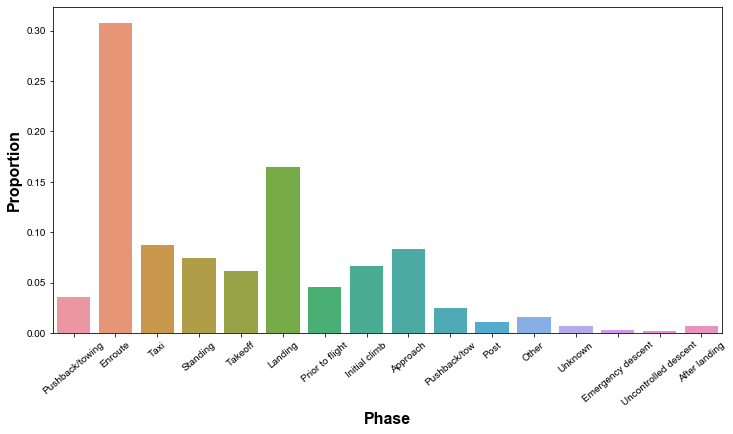

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

proportion = np.array(list(counter.values()))/sum(list(counter.values()))

plt.figure(figsize = (12, 6))
sns.barplot(x = list(counter.keys()), y = proportion)
sns.set(font_scale=1)
plt.xticks(rotation=40)
plt.xlabel('Phase', fontsize = 16, fontweight = 'bold')
plt.ylabel('Proportion', fontsize = 16, fontweight = 'bold')

#### Create raw transition graph from the Table Events_Sequence

In [142]:
nodeDesp = list(df_events_sequences['Description'].unique())

NameError: name 'df_events_sequences' is not defined

In [143]:
def findDespByID(ID):
    desp = df_events_sequences.loc[df_events_sequences['ev_id'] == ID]
    return list(desp['Description'])

dictEdges = {}

for ID in df_events_sequences['ev_id']:
    desp = findDespByID(ID)
    
    if len(desp) == 1:
        nodeFrom = nodeDesp.index(desp[0])
        nodeTo = nodeDesp.index(desp[0])
        
        key = str(nodeFrom)
        
        if key in dictEdges.keys():
            dictEdges[key] = dictEdges[key] + 1  
        else:
            dictEdges[key] = 1    
    else:
        for i in range(len(desp) - 1):
            nodeFrom = nodeDesp.index(desp[i])
            nodeTo = nodeDesp.index(desp[i+1])

            key = str(nodeFrom) + '->' + str(nodeTo)
            
            if key in dictEdges.keys():
                dictEdges[key] = dictEdges[key] + 1
            else:
                dictEdges[key] = 1

NameError: name 'df_events_sequences' is not defined

In [41]:
import operator

sorted_x = sorted(dictEdges.items(), key=operator.itemgetter(1))

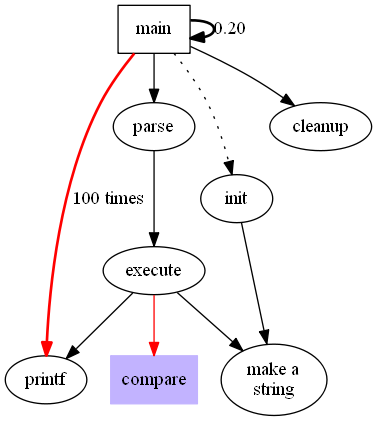

In [43]:
g1 = """digraph top {
    size ="12,12";
    main [shape=box]; /* this is a comment */
    main -> parse [weight=80];
    main -> main [style=bold, label="0.20"];
    parse -> execute;
    main -> init [style=dotted];
    main -> cleanup;
    execute -> { make_string; printf}
    init -> make_string;
    edge [color=red]; // so is this
    main -> printf [style=bold,label="100 times"];
    make_string [label="make a\nstring"];
    node [shape=box,style=filled,color=".7 .3 1.0"];
    execute -> compare;
}"""


drawImage(g1)

In [44]:
def create_graph():
    g = """digraph top {
    size ="12,12";"""
    
    for key, value in dictEdges.items():
        
        if '->' in key:
            nodeFrom = key.split('->')[0]
            nodeTo = key.split('->')[1]
            g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
  
    g += '}'
    
    return g

In [45]:
nodeDesp[21]

'Fire/smoke (non-impact)'

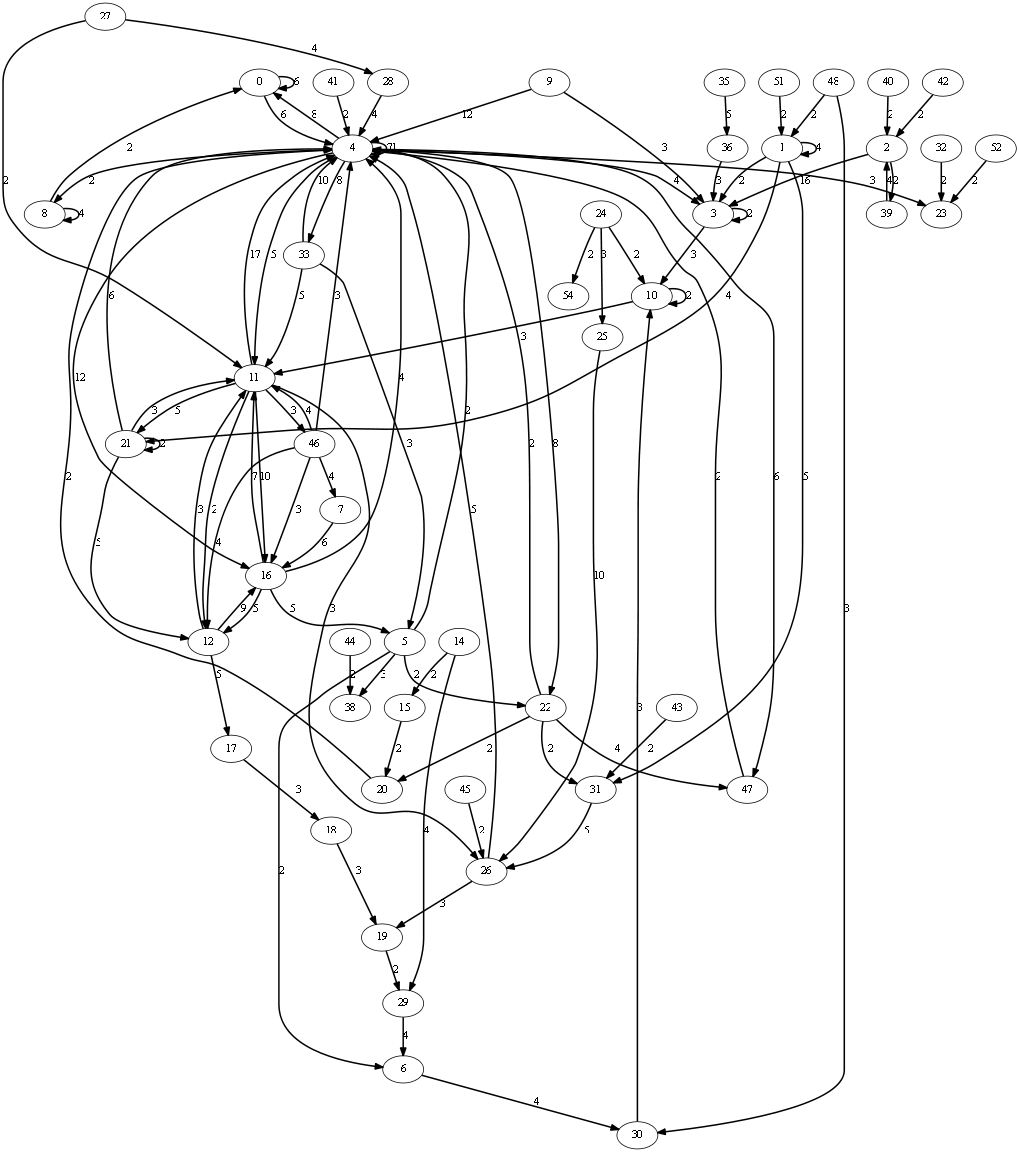

In [46]:
g = create_graph()
drawPDF(g, 'test')
drawImage(g)

#### Create compressed network from Table seq_of_events

In [47]:
initialIDs = set(occurrences['ev_id']).intersection(set(seq_of_events['ev_id']))
part120_IDs = set(sum(aircraft.values.tolist(), []))

ev_ID = list(initialIDs.intersection(part120_IDs))

In [48]:
eventCodes.head()

code                                        meaning
0   100                                ABRUPT MANEUVER
1   110                ALTITUDE DEVIATION,UNCONTROLLED
2   120                                    CARGO SHIFT
3   130  AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4   131                  PROPELLER FAILURE/MALFUNCTION

In [91]:
df_seq_of_events = seq_of_events[seq_of_events['ev_id'].isin(ev_ID)].copy()

df_seq_of_events.drop(df_seq_of_events.index[6218], inplace = True)
df_seq_of_events.reset_index(inplace=True)
del df_seq_of_events['index']

In [92]:
df_seq_of_events.head()

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
0  20030314X00332             1              1             1           1   
1  20001212X18554             1              1             1           2   
2  20001212X18554             1              1             2           2   
3  20001212X18554             1              1             3           4   
4  20001212X18554             1              1             4           2   

   Subj_Code Cause_Factor  Modifier_Code  Person_Code           lchg_date  \
0      10403            C           1137          0.0   7/6/2004 15:23:06   
1      24602            F           3130       4000.0  1/10/2001 10:43:11   
2      24608            C           3130       4111.0  1/10/2001 10:43:11   
3      90000            F              0       6110.0  1/10/2001 10:43:11   
4      24604            F           3134       4111.0  1/10/2001 10:43:11   

          lchg_userid  
0  JOHB                
1  dbo                 
2  dbo                 
3  dbo                 
4  dbo

In [93]:
df_seq_of_events.insert(6, 'Grouped_Subject_Code', None)
df_seq_of_events.insert(7, 'Simple_Subject_Code', None)

In [94]:
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()

def updateGroupSubjectCode(code):
    codeList = []
    
    if int(str(code)[:-2] + '00') in codeList:
        return code
    else:
        return int(str(code)[:-2] + '00')

df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(updateGroupSubjectCode)
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].map(updateGroupSubjectCode)

In [95]:
df_seq_of_events.head()

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
0  20030314X00332             1              1             1           1   
1  20001212X18554             1              1             1           2   
2  20001212X18554             1              1             2           2   
3  20001212X18554             1              1             3           4   
4  20001212X18554             1              1             4           2   

   Subj_Code  Grouped_Subject_Code  Simple_Subject_Code Cause_Factor  \
0      10403                 10400                10400            C   
1      24602                 24600                24600            F   
2      24608                 24600                24600            C   
3      90000                 90000                90000            F   
4      24604                 24600                24600            F   

   Modifier_Code  Person_Code           lchg_date         lchg_userid  
0           1137          0.0   7/6/2004 15:23:06  JOHB                
1           3130       4000.0  1/10/2001 10:43:11  dbo                 
2           3130       4111.0  1/10/2001 10:43:11  dbo                 
3              0       6110.0  1/10/2001 10:43:11  dbo                 
4           3134       4111.0  1/10/2001 10:43:11  dbo

In [96]:
eventCodes[eventCodes['code'] == 31100]

Empty DataFrame
Columns: [code, meaning]
Index: []

In [97]:
def findKeyByValue(val, highLevelGroup):
    for k, v in highLevelGroup.items():
        if val in v:
            return k
        
def mapToHigherLevel(code):
    
    highLevelGroup = {
        9910001: [10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 11300, 13000],
        9912001: [12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13100],
        9913001: [14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200,
                  15300, 15400, 15600, 15700, 15800, 15900, 16000, 16700, 16900],
        9914001: [17000, 17100, 17200, 17300],
        9915001: [18100, 18200, 18300, 18400, 18500, 19000, 19300],
        9916001: [21000, 21100],
        9918001: [19200, ],
        9919001: [20200],
        9920001: [20000],
        9930001: [20100],
        9940001: [22000, 22100, 22200, 22300, 22400, 22500, 22600, 22700, 22800, 22900, 23000, 23100, 23300],
        9950001: [24000, 24100, 24200, 24300, 24400, 24500, 24600, 24700, 25000],
        9960001: [30000, 30001, 31000, 31100, 31200, 32000, 33000, 33100, 34000, 
                  33200, 33400, 33500, 33600, 33700, 34100, 34200, 34300, 40000, 40001, 50001, 60000],
        9970001: [35000, 35100, 35200, 35300, 70100, 80100, 80200, 80300, 80400, 84100, 84200,
                  70000, 80000, 82000, 82100, 82200, 84000],
        9980001: [90000, 91000, 92000, 93000, 90100, 90200, 91100, 91200, 91300, 91400, 91500, 92200, 92300, 92400, 
                  93100, 93200, 93300]
    }
    
    
    allValues = sum(list(highLevelGroup.values()), [])
    
    if code in allValues:
        key = findKeyByValue(code, highLevelGroup)
        return key
    else:
        return code
    
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(mapToHigherLevel)

In [98]:
df_seq_of_events.head(2)

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
0  20030314X00332             1              1             1           1   
1  20001212X18554             1              1             1           2   

   Subj_Code  Grouped_Subject_Code  Simple_Subject_Code Cause_Factor  \
0      10403               9910001                10400            C   
1      24602               9950001                24600            F   

   Modifier_Code  Person_Code           lchg_date         lchg_userid  
0           1137          0.0   7/6/2004 15:23:06  JOHB                
1           3130       4000.0  1/10/2001 10:43:11  dbo

In [99]:
subjectCodes = sorted(list(df_seq_of_events['Grouped_Subject_Code'].unique()))

In [100]:
df_seq_of_events.head(3)

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
0  20030314X00332             1              1             1           1   
1  20001212X18554             1              1             1           2   
2  20001212X18554             1              1             2           2   

   Subj_Code  Grouped_Subject_Code  Simple_Subject_Code Cause_Factor  \
0      10403               9910001                10400            C   
1      24602               9950001                24600            F   
2      24608               9950001                24600            C   

   Modifier_Code  Person_Code           lchg_date         lchg_userid  
0           1137          0.0   7/6/2004 15:23:06  JOHB                
1           3130       4000.0  1/10/2001 10:43:11  dbo                 
2           3130       4111.0  1/10/2001 10:43:11  dbo

In [101]:
def findEventSequence(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Grouped_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Grouped_Subject_Code'])

def findEventOutcomes(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])


dictEventSequences = {}
for ID in ev_ID:
    
    seq = findEventSequence(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Grouped_Subject_Code']
                codeTo = seq.iloc[i+1]['Grouped_Subject_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Grouped_Subject_Code'])


        leafNodes.append(seq.iloc[-1]['Grouped_Subject_Code'])
        outcomes = findEventOutcomes(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictEventSequences.keys():
                dictEventSequences[key] += 1
            else:
                dictEventSequences[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1

In [102]:
def createBN():
    occurrencesCodes = list(set(occurrences['Occurrence_Code']))
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""
    
    g += """bgcolor="transparent"; \n """
    g_node_style = ''
    
    threshold = 10
    
    count = 0
    for key, value in dictEventSequences.items():
        
        #if count < 100:
        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])

            #if nodeFrom != nodeTo:
            #    print (nodeFrom, '-->', nodeTo)

            if nodeFrom in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ', fontsize=16, penwidth=3, \
                color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'

                g_node_style += str(nodeFrom) + """ [style=filled, color="gold"]"""
                g_node_style += '\n\t'
            elif nodeTo in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ', fontsize=16, penwidth=3, \
                color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'

                g_node_style += str(nodeTo) + """ [style=filled, color="gold"]"""
                g_node_style += '\n\t'
            elif value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [style=bold, label=' + str(value) + ', fontsize=16, \
                            penwidth=3, color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'
                
                g_node_style += str(nodeTo) + """ [style=filled, color="green", fontsize = 16]"""
                g_node_style += '\n\t'

            #count += 1
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [103]:
len(subjectCodes)

15

In [104]:
eventCodes[eventCodes['code'] == 10001]

code                    meaning
633  10001  FUSELAGE,CREW COMPARTMENT

In [105]:
subjectCodes

[9910001,
 9912001,
 9913001,
 9914001,
 9915001,
 9916001,
 9918001,
 9919001,
 9920001,
 9930001,
 9940001,
 9950001,
 9960001,
 9970001,
 9980001]

In [106]:
dictSubjectCodes = {}
for i in range(1, len(subjectCodes)+1):
    dictSubjectCodes[subjectCodes[i-1]] = i

In [107]:
dictEventSequences

{'9920001->9950001': 148,
 '9950001->240': 93,
 '9910001->9910001': 216,
 '9910001->130': 200,
 '9910001->9950001': 182,
 '9950001->9910001': 91,
 '9940001->130': 27,
 '130->320': 5,
 '9913001->9914001': 18,
 '9914001->9950001': 48,
 '9950001->9950001': 669,
 '9950001->171': 19,
 '171->430': 10,
 '9920001->240': 136,
 '9950001->430': 112,
 '9970001->430': 14,
 '9980001->430': 4,
 '430->430': 11,
 '9950001->130': 182,
 '130->230': 8,
 '9912001->140': 2,
 '9912001->9950001': 68,
 '130->340': 6,
 '9920001->9940001': 47,
 '9940001->240': 55,
 '9913001->130': 45,
 '9913001->9913001': 166,
 '130->351': 5,
 '351->171': 9,
 '9919001->9950001': 70,
 '9950001->9920001': 67,
 '9920001->9920001': 147,
 '9920001->310': 6,
 '9960001->9950001': 66,
 '9940001->160': 2,
 '9950001->160': 24,
 '9950001->9919001': 42,
 '9919001->360': 1,
 '9919001->310': 53,
 '9950001->310': 119,
 '9912001->9912001': 122,
 '9912001->130': 88,
 '9940001->9940001': 52,
 '9940001->9950001': 66,
 '9915001->9918001': 4,
 '9914

In [108]:
eventCodes[eventCodes['code'] == 320]

code                                       meaning
37   320  ON GROUND/WATER ENCOUNTER WITH TERRAIN/WATER

In [109]:
eventCodes.head()

code                                        meaning
0   100                                ABRUPT MANEUVER
1   110                ALTITUDE DEVIATION,UNCONTROLLED
2   120                                    CARGO SHIFT
3   130  AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4   131                  PROPELLER FAILURE/MALFUNCTION

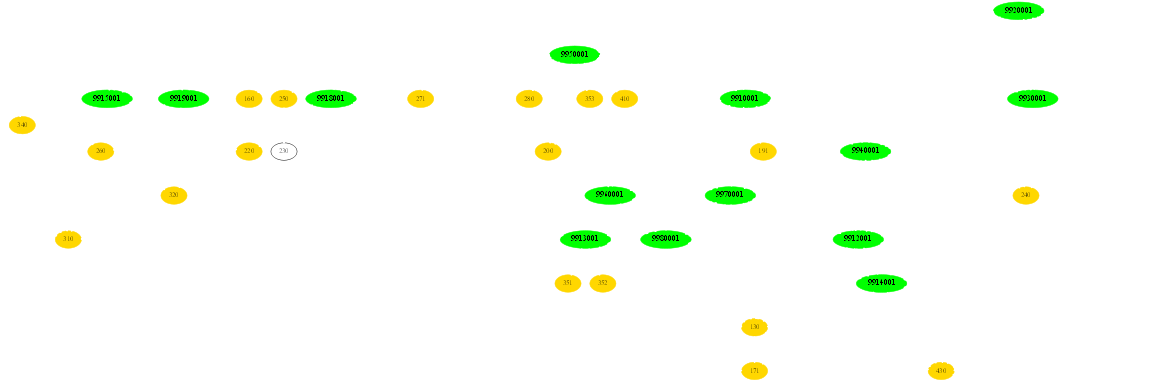

In [119]:
BN = createBN()
drawImage(BN)

In [118]:
drawPDF(BN, 'BN')

### Challenges:

#### 1. How to detect loop in the constructed graph
#### 2. How to break the loop
#### 3. Visualization --> too many nodes

In [320]:
df_seq_of_events.head()

ev_id  Aircraft_Key  Occurrence_No  seq_event_no  group_code  \
0  20030314X00332             1              1             1           1   
1  20001212X18554             1              1             1           2   
2  20001212X18554             1              1             2           2   
3  20001212X18554             1              1             3           4   
4  20001212X18554             1              1             4           2   

   Subj_Code  Grouped_Subject_Code  Simple_Subject_Code Cause_Factor  \
0      10403               9910001                10400            C   
1      24602               9950001                24600            F   
2      24608               9950001                24600            C   
3      90000               9980001                90000            F   
4      24604               9950001                24600            F   

   Modifier_Code  Person_Code           lchg_date         lchg_userid  
0           1137          0.0   7/6/2004 15:23:06  JOHB                
1           3130       4000.0  1/10/2001 10:43:11  dbo                 
2           3130       4111.0  1/10/2001 10:43:11  dbo                 
3              0       6110.0  1/10/2001 10:43:11  dbo                 
4           3134       4111.0  1/10/2001 10:43:11  dbo

In [321]:
def findEventSequenceSimpleCode(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Simple_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Simple_Subject_Code'])

def findEventOutcomesSimpleCode(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])

In [322]:
dictBN = {}
nodeList = []

for ID in ev_ID:
    
    seq = findEventSequenceSimpleCode(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Simple_Subject_Code']
                codeTo = seq.iloc[i+1]['Simple_Subject_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Simple_Subject_Code'])

        leafNodes.append(seq.iloc[-1]['Simple_Subject_Code'])
        outcomes = findEventOutcomesSimpleCode(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']
            
            nodeList.append(codeFrom)
            nodeList.append(codeTo)

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictBN.keys():
                dictBN[key] += 1
            else:
                dictBN[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1

#### Construct transition matrix

In [46]:
#### Label each node with a sequential number
#### Detect loops in the network 
#### Find the direction of observed node --> consequence

import networkx as nx
G = nx.DiGraph()

count = len(set(nodeList)) 
nodeIDList = list(set(nodeList))
TP = np.zeros(shape = (count, count))
    
## add node
for i in range(1, count):
    G.add_node(i)

## add edges
for i in dictBN:
    nodeFrom, nodeTo = int(i.split('->')[0]), int(i.split('->')[1])
    #print (nodeFrom, nodeTo)
    #if nodeFrom != nodeTo:
        #print (str(nodeFrom) + '->' + str(nodeTo))
        #print (dictBN[str(nodeFrom) + '->' + str(nodeTo)])
    G.add_edge(nodeFrom, nodeTo)
        
    if nodeTo == 290:
        #pass
        print (str(nodeFrom) + '->' + str(nodeTo), dictBN[i])
        
    TP[nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo)] = dictBN[i]
    
    #print (nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo), dictBN[i])
    
    if nodeIDList.index(nodeFrom) == 1:
        pass
        #print (nodeIDList.index(nodeFrom))

192->290 1
196->290 1
130->290 1


In [47]:
TP

array([[6., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 6., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [48]:
N = TP.shape[0]

for i in range(TP.shape[0]):
    if sum(TP[i, :]) == 0:
        TP[i, i] = 1

In [49]:
row_sums = TP.sum(axis=1)
TP = TP / row_sums[:, np.newaxis]

In [50]:
nodeIDs = set(nodeList)

for id in nodeIDs:
    try:
        res = nx.find_cycle(G, source = id, orientation='original')
        if id == res[0][0]:
            print (res)
    except:
        pass

[(12800, 12800, 'forward')]
[(24700, 80000, 'forward'), (80000, 91300, 'forward'), (91300, 24700, 'forward')]
[(80000, 91300, 'forward'), (91300, 24700, 'forward'), (24700, 80000, 'forward')]
[(130, 230, 'forward'), (230, 340, 'forward'), (340, 310, 'forward'), (310, 192, 'forward'), (192, 130, 'forward')]
[(140, 140, 'forward')]
[(10400, 10400, 'forward')]
[(160, 200, 'forward'), (200, 160, 'forward')]
[(91300, 24700, 'forward'), (24700, 80000, 'forward'), (80000, 91300, 'forward')]
[(192, 130, 'forward'), (130, 230, 'forward'), (230, 340, 'forward'), (340, 310, 'forward'), (310, 192, 'forward')]
[(200, 160, 'forward'), (160, 200, 'forward')]
[(12500, 12500, 'forward')]
[(230, 340, 'forward'), (340, 310, 'forward'), (310, 192, 'forward'), (192, 130, 'forward'), (130, 230, 'forward')]
[(310, 192, 'forward'), (192, 130, 'forward'), (130, 230, 'forward'), (230, 340, 'forward'), (340, 310, 'forward')]
[(12100, 31100, 'forward'), (31100, 12100, 'forward')]
[(340, 310, 'forward'), (310, 192

### Forward propagation

In [51]:
set(df_seq_of_events['Simple_Subject_Code'])

{10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 11300,
 12000,
 12100,
 12200,
 12300,
 12400,
 12500,
 12600,
 12700,
 12800,
 12900,
 13000,
 13100,
 14000,
 14100,
 14200,
 14300,
 14400,
 14500,
 14600,
 14700,
 14800,
 14900,
 15000,
 15100,
 15200,
 15300,
 15400,
 15600,
 15700,
 15800,
 15900,
 16000,
 16700,
 16900,
 17000,
 17100,
 17200,
 17300,
 18100,
 18200,
 18300,
 18400,
 18500,
 19000,
 19200,
 19300,
 20000,
 20100,
 20200,
 21000,
 21100,
 22000,
 22100,
 22200,
 22300,
 22400,
 22500,
 22600,
 22700,
 22800,
 22900,
 23000,
 23100,
 23300,
 24000,
 24100,
 24200,
 24300,
 24400,
 24500,
 24600,
 24700,
 25000,
 30000,
 31100,
 31200,
 32000,
 33000,
 33100,
 33200,
 33400,
 33500,
 33600,
 33700,
 34000,
 34100,
 34200,
 34300,
 35000,
 35100,
 35200,
 35300,
 40000,
 60000,
 70000,
 70100,
 80000,
 80100,
 80200,
 80300,
 80400,
 82000,
 82100,
 82200,
 84000,
 84100,
 84200,
 90000,
 90100,
 90200,
 91000,
 91100,
 91200,
 91300,
 91400,


In [52]:
state = 22600
eventCodes[eventCodes['code']== state]

code                meaning
1741  22600  ANTI-ICE/DEICE SYSTEM

In [53]:
initialState = np.zeros(shape = (N, 1)).flatten()

startNodeID = nodeIDList.index(state)
initialState[startNodeID] = 1

In [54]:
startNode = [state]

In [55]:
dictForwardGraph = {}

for i in range(1000):
    initialState = np.dot(TP.transpose(), initialState)
    
    #print (nodeIDList[np.argmax(initialState)])
    #print (initialState[[41, 66, 69, 109]])
    
    for s in startNode:
        # calculate the sum of all counts
        count = 0
        for key, val in dictBN.items():
            if str(s) + '->' in key:
                count = count + val

        startNode = []
        for key, val in dictBN.items():
            if str(s) + '->' in key and val/count > 0.05:
                t = key.split('->')[1]
                
                startNode.append(t)
                
                dictForwardGraph[str(s) + '->' + str(t)] = val/count

In [56]:
def createFowardPropagation(FPN):
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""

    g_node_style = ''
    
    for key, value in FPN.items():

        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])
            g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(round(value, 2)) + ']'
            g += '\n\t'
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [57]:
FPN = createFowardPropagation(dictForwardGraph)
drawImage(FPN)
drawPDF(FPN, 'FPN')

In [58]:
eventIndices = np.where(initialState > 0.001)

dictOutcome = {}

for i in list(eventIndices[0]):
    code = nodeIDList[i]
    meaning = eventCodes[eventCodes['code']== code]['meaning']
    p = initialState[i]
    
    dictOutcome[code] = p

In [59]:
dictOutcome

{0: 0.012270664217011644,
 140: 0.10466378306330312,
 150: 0.02735200547416189,
 195: 0.027578118071082645,
 232: 0.08676583710364927,
 290: 0.7264354854715852,
 370: 0.01476748909941251}

Text(0, 0.5, 'Probability of occurrence')

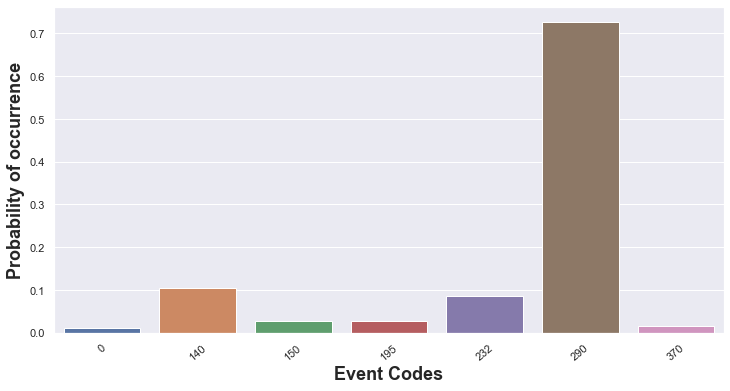

In [60]:
plt.figure(figsize = (12, 6))

sns.barplot(x = list(dictOutcome.keys()), y = list(dictOutcome.values()))
sns.set(font_scale=1)
plt.xticks(rotation=40)

plt.xlabel('Event Codes', fontsize = 18, fontweight = 'bold')
plt.ylabel('Probability of occurrence', fontsize = 18, fontweight = 'bold')

In [61]:
eventCodes[eventCodes['code']== 0]

Empty DataFrame
Columns: [code, meaning]
Index: []

### Backward inference

In [62]:
TP = np.array([[0.2, 0.2, 0.6], [0, 0.7, 0.3], [0.5, 0.5, 0]])

In [63]:
s = np.array([0.2, 0.6, 0.2])

In [64]:
for i in range(1000):
    s = np.dot(TP.transpose(), s)
    s = s/np.sum(s)

In [65]:
s

array([0.16853933, 0.56179775, 0.26966292])

In [66]:
tmp = TP.transpose()
for i in range(100):
    tmp = np.dot(TP.transpose(), tmp)

In [67]:
tmp

array([[0.16853933, 0.16853933, 0.16853933],
       [0.56179775, 0.56179775, 0.56179775],
       [0.26966292, 0.26966292, 0.26966292]])

In [68]:
np.dot(tmp, s)

array([0.16853933, 0.56179775, 0.26966292])